# Preprocess data 

### Loading data and dependencies

In [13]:
import numpy as np
import pandas as pd
import re
import json
import os
from collections import defaultdict
import random 

# Display imports
import seaborn as sns
import matplotlib.pyplot as plt 
from IPython.display import display, HTML
from matplotlib.pyplot import figure
sns.set_theme(style="darkgrid")
sns.set(font_scale = 1.5)
plt.rcParams["figure.figsize"] = (10,6)

# Audio imports
import librosa
from tqdm import tqdm
import time

# Don't forget to set up Beautifulsoup with xml parser (can be a hassle for windows)
# pip install beautifulsoup4
# pip install xml
from bs4 import BeautifulSoup

In [14]:
data_dir = "../data/sp/podcasts-no-audio-13GB"

metadata_path = os.path.join(data_dir, "metadata.tsv")
rss_path = os.path.join(data_dir, "show-rss")
transcripts_path = os.path.join(data_dir, "podcasts-transcripts")

tc_output_dir = '../data/sp/transcripts/'
if not os.path.isdir(tc_output_dir):
    os.mkdir(tc_output_dir)
    
tc_output_path = os.path.join(tc_output_dir, "sp_transcript_sample_03.txt")

In [15]:

metadata = pd.read_csv(metadata_path, sep='\t')
print(len(metadata))
metadata.head(2)

105360


,show_uri,show_name,show_description,publisher,language,rss_link,episode_uri,episode_name,episode_description,duration,show_filename_prefix,episode_filename_prefix
0,spotify:show:2NYtxEZyYelR6RMKmjfPLB,Kream in your Koffee,A 20-something blunt female takes on the world...,Katie Houle,['en'],https://anchor.fm/s/11b84b68/podcast/rss,spotify:episode:000A9sRBYdVh66csG2qEdj,1: It’s Christmas Time!,On the first ever episode of Kream in your Kof...,12.700133,show_2NYtxEZyYelR6RMKmjfPLB,000A9sRBYdVh66csG2qEdj
1,spotify:show:15iWCbU7QoO23EndPEO6aN,Morning Cup Of Murder,Ever wonder what murder took place on today in...,Morning Cup Of Murder,['en'],https://anchor.fm/s/b07181c/podcast/rss,spotify:episode:000HP8n3hNIfglT2wSI2cA,The Goleta Postal Facility shootings- January ...,"See something, say something. It’s a mantra ma...",6.019383,show_15iWCbU7QoO23EndPEO6aN,000HP8n3hNIfglT2wSI2cA


### Add extra columns
#### Add a column that contains a cleaned version of show_uri

In [16]:

def extract_uri(fullstr):
    tmp = fullstr.split(':')[-1]
    return tmp

metadata['show_id'] = metadata['show_uri'].apply(extract_uri)
metadata.head(2)


,show_uri,show_name,show_description,publisher,language,rss_link,episode_uri,episode_name,episode_description,duration,show_filename_prefix,episode_filename_prefix,show_id
0,spotify:show:2NYtxEZyYelR6RMKmjfPLB,Kream in your Koffee,A 20-something blunt female takes on the world...,Katie Houle,['en'],https://anchor.fm/s/11b84b68/podcast/rss,spotify:episode:000A9sRBYdVh66csG2qEdj,1: It’s Christmas Time!,On the first ever episode of Kream in your Kof...,12.700133,show_2NYtxEZyYelR6RMKmjfPLB,000A9sRBYdVh66csG2qEdj,2NYtxEZyYelR6RMKmjfPLB
1,spotify:show:15iWCbU7QoO23EndPEO6aN,Morning Cup Of Murder,Ever wonder what murder took place on today in...,Morning Cup Of Murder,['en'],https://anchor.fm/s/b07181c/podcast/rss,spotify:episode:000HP8n3hNIfglT2wSI2cA,The Goleta Postal Facility shootings- January ...,"See something, say something. It’s a mantra ma...",6.019383,show_15iWCbU7QoO23EndPEO6aN,000HP8n3hNIfglT2wSI2cA,15iWCbU7QoO23EndPEO6aN


In [17]:
print(metadata.columns)

Index(['show_uri', 'show_name', 'show_description', 'publisher', 'language',
       'rss_link', 'episode_uri', 'episode_name', 'episode_description',
       'duration', 'show_filename_prefix', 'episode_filename_prefix',
       'show_id'],
      dtype='object')


#### Add a column that contains transcript

In [18]:
def get_text(json_file, sample=1.0):

    res = json_file['results']
    alltext = []
    
    for r in res:

        alts = r['alternatives']
        if len(alts) > 1:
            print('Check what is going on here!!!')
            raise
        elif len(alts) == 1:

            altdict = alts[0]
            if 'transcript' in altdict.keys():
                confidence = altdict['confidence']
                tc = altdict['transcript']
                #sents = tc.split(". ")
                sents = re.split('(?<=[.!?]) +',tc)
                alltext.extend(sents)

    if sample < 1.0:
        num = int(sample * len(alltext))
        alltext = random.sample(alltext, num)
    return alltext

In [19]:
outfile = open(tc_output_path, 'w')
could_not_open = 0

# add empty col to df
metadata["tc_sents"] = np.nan
metadata['tc_sents'] = metadata['tc_sents'].astype('object')
metadata["tc_full"] = np.nan
metadata['tc_full'] = metadata['tc_full'].astype('object')


# Iterate over all transcript directories
for subdir, dirs, files in os.walk(transcripts_path):
    print("subdir: ", subdir)
    for file in files:
        if file[-4:] == "json":
            filepath = os.path.join(subdir, file)
            
            ep_id = file[:-5]
        
            # Open the transcript
            try:
                f = open(filepath)
                json_file = json.load(f)
            except:
                print("--------- Could not open json file")
                could_not_open += 1
                continue
                
            # Get a list of sentences
            tc_list = get_text(json_file)
            tc_full = ' '.join(tc_list)

            row_idx = metadata.index[metadata.episode_filename_prefix == ep_id]

            if len(row_idx) != 1:
                # Dit kan weg als dit 1x allemaal is goedgegaan
                print("Something is wrong!!")
                print(len(row_idx))
                raise
                
            row_idx = row_idx.tolist()[0]
                
            metadata.at[row_idx, 'tc_sents'] = tc_list
            metadata.at[row_idx, 'tc_full'] = tc_full


            # Get a list of sentences (now sample, for size)
            transcript_list = get_text(json_file, sample=0.3)
            
            #Write to textfile, one sentece per line
            for s in transcript_list:
                outfile.write("%s\n" % s.lstrip())

outfile.close()
print("Done mergin transcripts to one file.")
print("could not open {} files".format(could_not_open))

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/R
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/R/show_0rEzHBbqtuqgP4zEmKzqIH
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/R/show_0RQpGNWVQtBBwKP0TEPPyM
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/R/show_0R6EeMT7ViHV1rCqNw9FNg
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/R/show_0RFnIxovd7WWgpLXzzXrKF
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/R/show_0R9TiomLuJ7E84s8VHTYk8
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/R/show_0r1CLuoAK6A5a4PeS3cYwJ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/R/show_0ruY06AVqTtXm1Rs3bwDtZ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/R/show_0rOl7YvRSZlxqgkj4sV4sv
subdir:  ../data/sp/podcasts-no-au

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/U/show_0UADNFhQalPBIJ7yvdiE1S
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/U/show_0u4HXbWiDxk8SLLLr12YQl
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/U/show_0uik81Jiied80h8cQQvlUP
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/U/show_0u4laszAJMw5WXOhvYLJOt
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/U/show_0u6vgW6GwFrVOClRpx8ekA
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/U/show_0uV0CuvikoZhJU01Q4iaDg
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/U/show_0uWdanIRvaNizUGwEsB2yP
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/U/show_0UctWbKBMfXR2YnRXmWnF4
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/U/show_0UFhZ1rpIihtBdJ8G97wjL
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/U/show_0UHIYSDqDY4r9y8HB2OGGO
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/9/show_09KqYYMvpg3x43HQbZGIjE
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/9/show_09souwrfJyx8bLwYIZHHal
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/9/show_09LYhXbRq3uz0FvvVpS0rE
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/9/show_09w3o8TSHy2CXS8uYnIPzy
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/9/show_09hCjT9XXAKzGin8bkLG3a
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/9/show_09wpzRWQHYZpSeY7KgpCNv
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/9/show_09CuBwndsuxzPCbOS1nO4J
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/9/show_097uvXgvqJnKfNMvYLCbDV
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/9/show_09Ct1K2a7TnvYDNZRjw59n
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/9/show_09DmLdIA5HmHR1bgRN93Hh
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/I/show_0IWkmwGuorzfDvIn5GcRQy
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/I/show_0inWIcYLmzg5veEMiFbBp6
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/I/show_0IQxBA4xreQ6GlWGT5WNYx
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/I/show_0ihYOHGVSsn8hKXEB1FQI2
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/I/show_0IGaSdb3gKHlDSTATEEjHa
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/I/show_0IitcQK1f3h9rsch3EQDTA
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/I/show_0irZMEkgdUm7MtV4alErIJ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/I/show_0iaDy6TlrTV4mxy4RwbAbe
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/I/show_0i1iZ7CFLBgbt5ZhT8Uh68
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/I/show_0iCBsfhPtjEB8fzm8InwIh
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/N/show_0NNmMrIiwzNDVtLW1rLZTU
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/N/show_0NveZcLjhpWJnfpJhl6fHJ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/N/show_0NBgTzLMvjiw9iUVwDP1zo
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/N/show_0NyICI4rU1aCLNnZotm5gx
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/N/show_0nPmhxB8jSgxHocPH7yHAE
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/N/show_0NpSybWkKbwh9625CVhJbi
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/N/show_0nuEGO7nFVrNbjHBf9kdo7
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/N/show_0NLAANLyDkYuzl1ubcPI6a
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/N/show_0N8ttGEF4lnnflvkzhjf3I
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/N/show_0NP5nU17b58apLwugEMRt4
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/G/show_0gLgJsvxxr0mgac8kkR7ym
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/G/show_0G4U9tuCEl0k2eVgBH4RHx
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/G/show_0GbsJ6kG2gImpx7RUShsOd
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/G/show_0GvDenHcXeV63dJDpU9yif
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/G/show_0GJZo80cSxyCwakSTwgh0p
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/G/show_0gU7mxNAh7OEKCFVDV5957
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/G/show_0GyB3EIkXKkFO2NUFOPBBt
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/G/show_0Gzm0OcX4hEsvu2GDQBb21
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/G/show_0G8TmvpWgneBH8G5DL8YzE
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/G/show_0gbmXJbYhyOHtKsPqPShWU
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/6/show_06JMQHRjvdwCRkYh3xlMmG
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/6/show_06AtKtw9KB9aIpV8nrSdMG
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/6/show_06EkS1byRBRWU1zfTq2j0o
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/6/show_069j9hF23ngLRbTiwBtLUK
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/6/show_06aQrlbNH9mIQ4NBYJ4nKg
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/6/show_06g8Irz9Vq0dQ4uzzinB8I
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/6/show_06Yi5uH6es5fV4saORHvya
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/6/show_06IYDu1m5hagiXIMlFbJIg
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/Z
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/Z/show_0Zt79Xu48APecgjye2p1fU
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/Z/

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/1/show_01dN8woYX5yoIIGnzcRxQx
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/1/show_01M9q6xkNHZXloDtLblQqg
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/1/show_015DbLwcXu2fK7e9jIfbFo
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/1/show_01fcEnuxviKFvFb1lahYHz
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/1/show_01pPy6QzJDwdR9lquzjkE0
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/1/show_01p6u4RY07r0kfV0oTrLXn
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/1/show_01cZoFqOcp5NQwgXHQ0hlG
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/1/show_01C1tmSf1mwZwKk13w94Nt
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/1/show_01dYvt7dnlpN6ThxZRzSUk
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/1/show_01Czrt2h4wRtwtsvxAGsRt
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/T/show_0T7XPAp2jUHun24oi4rD8A
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/T/show_0tN8aZWZ5GKbkc0gzUUFDP
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/T/show_0t928Ul7oyGVnFnbUgTgJW
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/T/show_0TtmHF0LodTKetELuu73Bt
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/T/show_0T1MOLde3KEKAdQoc6ltb8
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/T/show_0tGr1xo39gBCElw6MI2YE3
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/T/show_0ttuYHbQwaZ293ZE3s72TY
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/T/show_0T2yVMz8l9ErHGX7FDFmzV
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/T/show_0t9kmV5SO6fLH1ukh07XEb
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/T/show_0TmX2Yw9gdnd2I6XEN8TpA
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/S/show_0swDyTXYzD75IAzqZH65aJ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/S/show_0s4GZoOEiugfx81nsKrpkL
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/S/show_0SEPpoDeMHyWM7qPUGhsYs
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/S/show_0sIIwchVv16NXJLvYUSRM2
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/S/show_0sZb7S2hiqD90YzpPn03cg
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/S/show_0SOmSllwfBhh6popf257o3
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/S/show_0sJgi4RqyPWyCMeMeTHpEG
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/S/show_0sLD2mfw2npKX05RmUzRIU
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/S/show_0S7u0bBLG37ymncyK4UmGn
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/S/show_0s7gHrTpBxeYkscpbVZk8u
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/A/show_0AGBG9Ouak6YxRVwz3UX5b
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/A/show_0AAtqnEfHn9xFu9ipyTKsm
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/A/show_0A687y2JO7FLkmsjik3i7f
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/A/show_0a6Suc2dGXjbzX3gdvotWq
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/A/show_0AuRNgDVG2WieJxvno8YGn
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/A/show_0Ajqg8XR52bP9N5sH2w3ww
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/A/show_0avUeJZuuCjNPUzLzQrokB
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/A/show_0ad8bobPbaG0AGWATTaHEU
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/A/show_0aSwPSpHuHwFAT53QViN5E
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/A/show_0aFtu5lHaNVcEUaUjZf6EO
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/F/show_0Fu2MfK3dA7lb21IngEJyc
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/F/show_0fqFwF5nIuEVblGYG5cimv
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/F/show_0F8qFNcdPZUqTXwDMWl3fL
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/F/show_0fjkId7Y3lW9YVyGyBrD5c
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/F/show_0FGoh7Wn2rntd2086M72aj
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/F/show_0fKIfBFEkOhIC7mSjGBcLI
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/F/show_0FdEy8v0VPnScGEaoUuUgl
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/F/show_0FBVNUdDuMQkCS5yknfHIg
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/F/show_0Fdd67FSfcxLcoxB0FYvWz
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/F/show_0fBt579jPvB77mQiJH8uyv
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/O/show_0O2YGHZXEccpdlZiUD6Yx7
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/O/show_0oNTzhK8mxdR2KOt2TH2Zf
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/O/show_0ORT49GNKZ3gOjS2UdWRQQ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/O/show_0ortzk4k0dTi0jB0I7SIKP
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/O/show_0OBHX9ti3cAtHa3LArLCUH
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/O/show_0o5soDokDsEBDjgJmcRVfw
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/O/show_0O6H4iHX2SHb3TyGwubkAw
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/O/show_0OHMYcZChEVgTx2jz0yzze
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/O/show_0OddYgMEJFufX7Wu3sDJUX
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/O/show_0o9FhNEW1JWDhWEqG8dZx6
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/M/show_0mVQH3swKBAl62nv83iqIB
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/M/show_0Mn2BngsNNiImHQ10jXWtA
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/M/show_0myRe5mjF1FKIO9ic08Hgr
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/M/show_0MrXdNa1jz0w1o7jj89CFR
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/M/show_0M5KOIqXz4cefpUHHhUwL8
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/M/show_0MM0uvptfOiTqWIRsYm31z
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/M/show_0m4Uw6ng4MD1qeePj6ZYL4
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/M/show_0MlY9q2VgnlXgLP48LNueH
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/M/show_0mLq6cxvLbVzVi6KwyJVXz
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/M/show_0M3xsdGVc4vWTquA6u6hjS
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/J/show_0jxBpUgFliZGNxP2fjZVej
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/J/show_0JO5Ryrr1hLTkFVey4oJEY
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/J/show_0jPWGpnDggXzfvjrVmZWYP
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/J/show_0J3uQB8GcfCek9JaaszeaH
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/J/show_0JZ2opnltlJ6PJxlZEpx9r
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/J/show_0jbtyhqWIzNxO52MexVKK6
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/J/show_0JCX6Uxm49LL4a6COGgnq6
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/J/show_0jRPrQH5ZIfINOiP3D3Zyp
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/J/show_0JNMPh4b5PAkU0qijN2cv6
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/J/show_0j88b0dVRFwISyrx1RYjPd
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/C/show_0Ch8z8dslMqeWKlMOIFr4s
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/C/show_0cqfjfxTrXvpxIMSZKFNBi
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/C/show_0cDoLa6C6TGML40ZlUlF2o
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/C/show_0CmKUCZwU2vFRxZpXXNQhF
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/C/show_0cLAi0qjIg5Izfl41cz4zC
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/C/show_0Cou8D3IK1iLFdctQ5XeRt
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/C/show_0cQiFflA7PiZbDfCDVL20v
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/C/show_0cZcK8pCajXiSnOCWzHpBp
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/C/show_0CGrPKmug9JWgMzJhml5Dk
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/C/show_0cOT7YccrBiKa8PyQftsoY
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/D/show_0DM2CWgQfdcsHDXa5KO2KP
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/D/show_0d5mFODaNoU1tAXIIYg5Jx
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/D/show_0DcWagqWQgQ3jmNoqtmuEE
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/D/show_0D2yM90a2uW5Vzgk6gXn7u
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/D/show_0D8UHOAq13gZP9f0QjRXQk
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/D/show_0dA1W1ItlspFfTqpbTMIBc
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/D/show_0DfUJVQa7SIiT42ACIGWTv
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/D/show_0Df6zKfp8OYP6232AcXrrp
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/D/show_0DaQbeGcrVz49jY7KzHOju
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/D/show_0D29Iek3FJhT7DLXu6uNgw
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/V/show_0vvk1bBb8dWA1dhf56ABP0
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/V/show_0V3P2N5XX7utse8cJGwZeA
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/V/show_0VhFBxx5cxwD1tAXwFaqtt
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/V/show_0VYywjf9VXSbmZwsc2NGjq
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/V/show_0vNQfx1EdYbFrnyWQdHEqp
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/V/show_0vevUlVo6IzwwA1kxe6GBJ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/V/show_0VjE8gR45bGf3TiJpaxvND
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/V/show_0vrjZUCbJkCQWNfvslBUC5
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/V/show_0VGXgdJWSx35hoiTvs3G0J
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/V/show_0VblrPv0GkkfX7PQe21WC1
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/Q/show_0QAnWQgP1cb48XxUuCeKHV
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/Q/show_0q0MwivmxXZuunicS1e0t9
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/Q/show_0q1KLW8NJQZbbgJY57lIpW
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/Q/show_0Q3ZDfNbo4iloYXZoONeO4
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/Q/show_0qKuChzR9dWZy4CN74vxRk
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/Q/show_0qw2sRabL5MOuWg6pgyIiY
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/Q/show_0q6OUtWyYl8LQecfzocJX7
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/Q/show_0QpXdxzbgzdsNtO5hcNZD5
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/Q/show_0Q0kCUbrW3sMukGHrglYiT
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/Q/show_0qHpwkGN55PlgEkS7geSAz
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/X/show_0XcucrzajWpEksmmjEx6ME
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/X/show_0XDJscLjTvTj2ovjxPmuDk
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/X/show_0XfUqztCcDkQ6kVlCwXPFc
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/X/show_0x4CAHbgWy8IOBfq8Yp2uB
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/X/show_0xvjxzfWgSjxg5fAxJz07f
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/X/show_0xRanguYxuRpAcckgt9zj2
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/X/show_0XYMHpcF6r3hy1EWRPyLK9
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/X/show_0X2HDSlMPFRsj69tIK6DXT
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/X/show_0XAypvG5bBdDZGQGK3yyJo
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/X/show_0xaJFLG2JYYlnp09Fv4qH1
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/E/show_0EFchOxA8WXCO8NFMRykyU
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/E/show_0eT5w7bW2FFileWHUTLgDM
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/E/show_0eaD0rz3H16DH0Ca56Z5Qx
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/E/show_0eW603MhU2xiqb6eATFakL
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/E/show_0EaY7aEiXvm9dizXwIEIlR
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/E/show_0eoB9h3f4SGxDUKqEibBwo
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/E/show_0Ei4ImBuofSvgDOgBtqgWP
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/E/show_0E3OHpIehQf92UZyHxvCLO
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/E/show_0eJLO1xtx1KSPzVmTlTXPS
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/E/show_0EgK0yecLM8hqHGY9WtEqN
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/B/show_0BtfH2LbEkhW0VBp81CUJY
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/B/show_0bqwvVw7wgsomkikMz6MPt
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/B/show_0bdLmKhRcjZi84t0KGq4kc
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/B/show_0BsuT1EEcZReDWH7I8ZCt2
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/B/show_0BeVwmTvA777diKbmc2jdD
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/B/show_0BHHNkrDIQnhuF26mJ7Kxd
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/B/show_0bvipReG8S6ZhfHquDUc2g
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/B/show_0BxnpzwjhO5YsB2h8wFAQp
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/B/show_0Bf3CjRUghITd4Nq2zrdh6
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/B/show_0bEHMsazYW9a0ILt3ID7BV
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/K/show_0kePVzG0hT7dtP7iCZzjhF
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/K/show_0kLBjZLIzuqptijzBuN06u
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/K/show_0KQog0DsNOE7jZNIlMkS5B
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/K/show_0KkzNmGh2ihwtciMpBJokB
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/K/show_0KyQeBnmQHEWTxMAENUv3T
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/K/show_0kAYY5NPGnLBMBteYqfBzZ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/K/show_0KbQ39FLDGiQkEq1WMcqjV
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/K/show_0KGD1H2eEoR0XL1oCZe1Ik
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/K/show_0kiNuNSYcrx7iE0v6oNlDl
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/K/show_0kSinznWuH3ACxOzkKGhdc
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/L/show_0LrFW03f2WDtBIDNRFcbz8
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/L/show_0ltsGVX4PTb9P54bbwvvIx
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/L/show_0lqcBbso2XqqStcEXz3t7H
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/L/show_0LTdsaBfIPbSe9J4zaZcJU
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/L/show_0LaYlRViq9hVwwGykQLHd3
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/L/show_0lRCEcCgCGtUx02kAMF127
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/L/show_0ltgvwS6zPDx900RbKutjb
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/L/show_0lkhdJ4kZVNherNmqwTjmv
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/L/show_0LgQ7hTQpU7MABLYazE5vG
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/L/show_0L8A1rmxm7lU3ARMHn2EGi
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/Y/show_0YYN4qbmmJG00fwbZOSRPj
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/Y/show_0Y6OgqzNr18vNrdRZUrXTs
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/Y/show_0yzrB84HYJC10jvtlVpZjI
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/Y/show_0yz28ZIs0G9d8CikqO8NZl
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/Y/show_0yJDLPK5nniT9Zj8LrzT00
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/Y/show_0YOJ8WFrQ2dUo8zwa2KhTe
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/Y/show_0yxVJ22O8ZEc2nRv8D9ngB
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/Y/show_0YCll9TO7m8t3ROy3VMmYI
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/Y/show_0YMbbmaeolxtbr53hQr3PB
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/Y/show_0yv1zY01Vi10bcpZeCWSvg
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/5/show_052zSMPkqa3VK8yJxPlPRK
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/5/show_05KH0KHWjXJ037VNeF9a77
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/5/show_05Ka64YMS8HpGifZclQrVx
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/5/show_05TuuXVszLF6VuuU9GehAZ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/5/show_05G9OZNK3VNIqc2yOXTTsq
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/5/show_05occvCcKPc4xksdZgjtpE
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/5/show_05GXUf7kFmmCbq4ALmbStP
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/5/show_05wdQTFhLOkUvXceD2j967
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/5/show_05EHHgKhaNSTmJrLzc3cLk
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/P
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/P/

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/W/show_0wJ042KTHoSZikpo7oBfJx
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/W/show_0WBFraCL0647Gfelm4XvqQ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/W/show_0wl0eQthpu9dNkwuAsvmaB
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/W/show_0wE7ByUuHGu2H5KEgxHfEY
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/W/show_0wozzoRl5yqcn0ey7g45Cx
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/W/show_0wdzqaJ8WK1RX3zRGXiBtu
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/W/show_0w36fDq6DOSzSAjRcpcfbG
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/W/show_0wkhaV6TvDG9QVnNnOGnob
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/W/show_0W5wkPcGrZl9YrAn4dGEvV
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/0/W/show_0WmUODTz06mvuzJjL3sqZx
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/R/show_7rtxUUJiRsCANyZKwWS5r0
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/R/show_7rNG9l3j06xmWlq4tUULfK
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/R/show_7rAolxBjL2mq5Dq9osvLmE
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/R/show_7rUzFFomO3Syt7jXRqoC23
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/R/show_7r0co4M7atOAlwGQZbgZkE
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/R/show_7rTbWAgf7jqxzwZFlcYEgS
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/R/show_7rNLxmbAXhzA2WQBXnzySj
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/R/show_7r25Cl9fW0rptczIpouCgX
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/R/show_7rYfi61FbFPkaWafB054gx
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/R/show_7r8BD2pQCv9Qd4LxQxk6R3
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/0/show_70vmtWGKQ8qNZvEZaoaWw3
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/0/show_707rEp5WZTswrw4oXUuylq
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/0/show_70yZcyEtjaRQohmz2HzGIl
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/0/show_70YYH8M9vaPUQMeCTpnmZt
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/0/show_70GHuadVsEoFg5neYM6e2l
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/0/show_70d62gvq2QBTIWRmPFR8Yo
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/0/show_704haVxKYTH3aQq63NiE4s
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/0/show_709WCJZY98sD9pj8p00IfV
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/0/show_70jpxInou1Hjf74nPNISVz
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/0/show_70mnFVpGlqCwnFUlDlQCAX
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/I/show_7iqe5gesiF9J60NE0vG83U
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/I/show_7IGH07CRJFM6hZ7DAymF08
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/I/show_7IMpn8F2ZO979g9TzNLdzW
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/I/show_7i2TzxJRIAe4ICtBVZkKkv
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/I/show_7intQ9S0SnMpDMEZjdh2AJ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/I/show_7Ieeo24W6b6ZUiXYkZpy9k
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/I/show_7I8rcP4QccAAibexx7DwBt
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/I/show_7Igxh4AyplIOvBK29goakV
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/I/show_7iGiKLac34V9ZwI9gh4AQd
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/I/show_7Ijan8h7XQmYbUMkYElkWe
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/N/show_7ndWuoDaVWUbdMdtGCr6ab
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/N/show_7nB8aAh2kMOvDbBmNY19TT
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/N/show_7n2Q57UE4XYhOjW0EDuPyU
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/N/show_7nGTicCiyL2pOiddRJUkNV
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/N/show_7nz7dBRMOuy9cpjPwmcHfa
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/N/show_7ngSYmZHBiQBeYW5IC84le
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/N/show_7nA2wYr8vytMPzPFMyaIsq
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/N/show_7n7dgnPvjkWkPjsxU1NtKp
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/N/show_7nXMPc0w3wlVoPprNS8Yjx
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/N/show_7N3U646Y0J94BZqUUsVz1W
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/G/show_7gYShc7tUPWDbecfaGRmax
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/G/show_7gTA64rKRPxJpjif1LjrM9
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/G/show_7gWQV7rdM5rUVah9f3ywdH
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/G/show_7gHkKy9EFJmcbkgingIDq7
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/G/show_7G264BHcz5ulGyl2Y5hFLP
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/G/show_7gpmPhrFM2SWtJLNNohB8I
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/6
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/6/show_76KFSnVFyIbY6f597255Dt
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/6/show_76bHN0zmR0ixLaledqBWrD
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/6/show_76wQcEFDNEv9Z4fNxmiytr
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/6/

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/Z/show_7zKiEEVCCIQaxNxXmbXcOi
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/Z/show_7z7BHYjTDP45kdcJab7oWa
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/Z/show_7zF8fOagK1E4sFm8oYqr5e
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/Z/show_7z0Zfn7ykeRtAlc8FP6smZ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/Z/show_7zcyzVdsBrKLFFTAH11nwc
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/Z/show_7zzkvuWptdxJnN3ezTrKNl
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/Z/show_7zDyGcCWUkfubL5bfgJ9WG
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/Z/show_7zaB8zcKpdSUSvCERivoUj
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/Z/show_7zg1CGAgCmIXqewPJ5LDFN
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/Z/show_7zczGPfySJjnwWkej89LiI
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/T/show_7tPUEURWgexXAsxYbLxTRA
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/T/show_7tQkhNdxaEpjnJvXGFxctS
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/T/show_7trZPJfageC2bpI1qCyzLo
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/T/show_7tea80lgxJHPvNJrj9HoFs
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/T/show_7tnlPEjVQvfGzq8KN8nUT3
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/T/show_7t4t7Z4LFaOVFcmYDxyuw8
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/T/show_7tJ6xvTTsMJKgSc9kstPsJ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/T/show_7thqTd7Y8ZUnOBqsEjuVcR
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/T/show_7tfLgcc9RtCkByBQfkwWbL
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/T/show_7tdDcr1ANr6DcBHMVvCjbM
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/A/show_7a0eBFuZ9bxfhm6rFCNFf2
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/A/show_7aGLm9HYn9mEyVr1FDzrpa
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/A/show_7A29o4zSPsaeyX5GCzXTeZ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/A/show_7AEqzHXi2qMEiEWVABXzVw
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/A/show_7a5PCPCgruahxHN63Senvq
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/A/show_7aPpK6lbbT7lnftkdY0xoi
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/A/show_7a2nsyURhSOFl6142v0NrI
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/A/show_7a5ezsax19ELxzf5y291k6
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/A/show_7aRERCbBWEVxrwBX6PdW6Y
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/A/show_7a8Gjvd9u74UDhUtyU9YdM
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/F/show_7f3gZMfn0C4R4O3zgYk7db
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/F/show_7fFLGMepy6EO5JXZoHPHmG
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/F/show_7FJTAyGnCNjmknc5VHbKle
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/F/show_7fkpQjmmt2nLZrX43hwUPc
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/F/show_7FQpbZ39tqH2PighXRYPkP
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/F/show_7FrSzrMBu8JWu435D5XrCD
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/F/show_7Fkya3VsHbKRLG6N1Ytkp2
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/F/show_7Fg2z8xRvmZ8IXLJYz0aF5
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/F/show_7fs6zF2JNkXSFUcm8WYd0S
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/F/show_7FxE6W4t3khpy7wTeDJthx
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/H/show_7HtldTM3MW58zH5rUyQ4R3
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/H/show_7hqECPHM6UMe4Kw0B0lAOU
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/H/show_7HRgXxOq1wTa7Be7Ksacqp
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/H/show_7HUq1K3DMvcZHCv0D8YzZr
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/H/show_7HGtIhqRRciMLj9KfnpUTx
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/H/show_7hXUqmuQNkSx0pOQ5yhNFv
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/H/show_7hL7K4zVLAKjCedB4NQ1hK
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/H/show_7hhEbl4DOMheWRunCUAla6
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/H/show_7h6wCWnjsgOIZSR6h0DKbq
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/H/show_7hD57wq1eWBrkt0Wrl5wOh
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/M/show_7mFYkNkid1HO9UmcIJYV3b
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/M/show_7MLffzPF8pvsHrGWJy1Til
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/M/show_7MJFwmStTiKT9hxUcipmsz
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/M/show_7MmoZ0AoiA9FSwDXkziIOv
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/M/show_7mApBab0tChX4FUBaIgg1P
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/M/show_7mQp5X8OlySzhJhxN1C0xS
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/M/show_7mpyyBnCHxa1COePqJYpzC
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/M/show_7myggQ6Ro2H4iZFJJAkiB8
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/M/show_7MhMll8LpV4LHDRmgV9hv3
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/M/show_7MorResd8JjKB558Yme3fz
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/J/show_7jPfyIf0PKveblaDCTqTOZ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/J/show_7JZZfTb9fVbsMijvnTSyaK
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/J/show_7JiDtm7hc0EfSW9LjCXDaO
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/J/show_7JEirIy9KWdoNkfdBt07v2
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/J/show_7J9i7giwieV6yVQU1GO8En
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/J/show_7JnuxqaG9oSOBvOaJugngM
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/J/show_7JFTKtRIRjc5EWYzUyvFw9
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/J/show_7JqILfGGnHGJctvuHn0Bm2
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/J/show_7jQukskw1MxyeeDG4uTfx9
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/J/show_7jk14EBYuKwIUReOtaJI3G
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/C/show_7CyVQicWOY7xhzhQeuOfMe
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/C/show_7CVqzCJpijgEbVz0SJuRoq
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/C/show_7CgYC9n7rpX8572E69qgTZ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/C/show_7cCODa5fRj2iA4xgsnpSiM
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/C/show_7CdUOBDsdgrGePfvzmshxY
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/C/show_7c8HVqiUgL3Yke6xsGbwb0
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/C/show_7crmjuCptGXkd5o8hYrWxi
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/C/show_7CqczZK7ohx0xTuoqD5wAG
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/C/show_7C3HT0wU7g07aY9tGondX9
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/C/show_7cOqTp63Pxrdg3EK6h8NXG
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/D/show_7dKbTPLqwCVu0Mt46Pp4Nr
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/D/show_7DEgcia50zEovrxfVT15gk
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/D/show_7di3we0I99kiS5quUQ3Ijo
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/D/show_7dIcyUVPsy25vKpGXevZfp
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/D/show_7dTuF2DJaBFk0WnHfjlJZD
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/D/show_7DCIV4DPz3h9gmZgL8Be3q
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/D/show_7dAEfQzbV27WoQt04Qco5S
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/D/show_7dXt1qvKqxGcuIcJX4m045
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/D/show_7D0dQwmkV6LleV7u0whj2Z
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/D/show_7dXblACEU0UO8LdgUKc2WC
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/Q/show_7qrubGGE1AH5WtKIFigePT
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/Q/show_7qziB6EjwGV3sMirNFPJgx
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/Q/show_7qNJtEhYeErVuqfYFWZ21J
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/Q/show_7qLQcXs5ktDwXJlQtEZpfG
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/4
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/4/show_744F0B7JbWlNnjZ9Vc1ttT
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/4/show_74Lyz3DYggu24cgaG4mjZZ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/4/show_74Vznu2xXjSJ8xcztiWYam
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/4/show_74A8irqD1mNSJBYcq6idRA
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/4/show_74Cby6I5J72Q62bivUSmVV
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/4/

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/X/show_7xDw8D4hcnyEcn0Gkb2e6K
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/X/show_7x1g9vf5u2iTdMspbDbxTj
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/X/show_7xq6rjmT0cVgHddquMk8Z9
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/X/show_7xXi50as3gW7CwB28to6TD
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/X/show_7xa0gRs8zdaHQKi4AzAgCg
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/X/show_7xuO5fKfNqML49dzknFJRh
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/X/show_7xVEA0r1FfkhJ8LTDqrGIe
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/X/show_7x6XeC8VnJnXZchzfTf6SW
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/X/show_7xFzLPhMMEcwjp6NMaGNE1
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/X/show_7xWs0nT6C22zV4zegm5afz
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/E/show_7eRPS5IKNPkU7jrguaubns
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/E/show_7ecbHefLI3mhmr8vZbkzYB
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/E/show_7ehgs0JXaydueyrKESkQWg
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/E/show_7EdTaqgy9HTcnoZ5XVr9Qo
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/E/show_7EKvABsiBAqPcMf6rqYNfG
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/E/show_7ensEidwWRlQGERdwJyIdM
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/E/show_7eO4Xp2Dd18S6EbqUE8hoa
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/E/show_7EXC7jFc6o9NCLan18swfS
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/E/show_7eaYIw8KBkfj0j9mTYgj8J
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/E/show_7e8E2PTeABQcc4qJbJapcD
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/B/show_7bbMbQU43FhVrOH8xoiptB
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/B/show_7buQvszwzFj6OIt25brtiz
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/B/show_7BXf2tKawzpVq7aX0ukgzp
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/B/show_7b2uGP2pWbRklqzmGStPXH
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/B/show_7bFQPOOw3HrHpNdfMckQqs
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/B/show_7bzeE9CHk0AJTOuA2liO8N
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/K
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/K/show_7kMaNBAx8mhygtZZzth00X
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/K/show_7k2gNSLZnopnh6pcvkQACK
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/K/show_7ksftRJMWCGwFEiXqjYVak
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/K/

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/L/show_7LjtUaXRRcE1eEOMSWaoxw
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/L/show_7lzvByM8ovm6DQt0MDznWg
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/L/show_7LzT9kNuxmH2qcurpy6uHk
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/L/show_7lXvmbhahDs9U3F50XrxUv
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/L/show_7llZNePdGQTjcoQ5PHjpEl
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/L/show_7ll7a4l8JsxEzw5pDPdHLL
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/L/show_7l1FOtWHzZnhracksxVDe9
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/L/show_7L0x9PlwiK6sQLodZlT7jN
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/L/show_7lrRLBR5Wbz67jr9Hvyw3r
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/L/show_7lcYllZQkUnmpIimytZxyU
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/2/show_720hm1SWgvyusW0zPeeSUW
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/2/show_721Md10iWWr5FSc3krYBgU
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/2/show_72oOQUrVlmpQcQ0DJhOsS9
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/2/show_72YBUjANcpAgd6zkzsJ3Ej
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/2/show_724a6ZvY3fNvgLgm1ESHKx
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/2/show_72AM51rNTKPZiewBG4VcGS
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/2/show_72meA7PUw2ndWl4A3ZhVDk
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/2/show_72FvcxQnGEpHwLO6kQr4Lo
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/2/show_72NF4fLT5mESCgoUKWPEH0
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/2/show_72CNszMWtEEiPWjYUZPz8B
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/5/show_75urupqqKJV5hq9ItZRDJN
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/5/show_750Psqs1tVzW749HKfQHtA
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/5/show_75WA0wvK9kyDWgwoY9lErU
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/5/show_75HobdF6kGkirVeMFtVLC4
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/5/show_753H4p7PxPHDRahFq3s6YF
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/5/show_75u7UCHjW5hdEEHB7AVbvQ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/5/show_75jJuaM0jzNzqAUxmovfY7
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/5/show_757onXbqI7alp31kvHHGqr
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/5/show_753DHupk45PqdSxFNItemk
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/5/show_75aC7eCpNrvJ0NvaCZV207
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/W/show_7weVeunvFSINzf6ynSBMXO
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/W/show_7w3h3umpH74veEJcbE6xf4
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/W/show_7wrMsF3oSUX7W108ECCUD6
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/W/show_7wzjNUP2goEoZLXLL7sGOQ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/W/show_7wDv3YPEfQXXlOfMC0VduU
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/W/show_7wb1HCNaydPhkLTqn1OleY
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/W/show_7wMDGH4MzOsbBaQ6ovPufs
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/W/show_7wd4F1RZw7aQKN4K7cVakB
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/W/show_7wAhR2Yx2GYlEnk9q9sRaF
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/7/W/show_7wLR15c83Da0efKLQ6JuNE
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/R/show_6rbOXqx6c2s8ffSPKS34bW
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/R/show_6RfnzJqrQyg1DiJFFDjz4y
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/R/show_6Rzl55qrPHaWFjEVW2Wqro
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/R/show_6rxl318uhVyDMqvUPhYDwm
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/R/show_6RLLO7VvNAecxJESCnQnld
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/R/show_6Rds8pRcfTTQeN8Ti1OQeQ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/R/show_6RqjcyVcwgg5TtHor5lL7m
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/R/show_6r7mrgXxVCVOwCH0BGjP0s
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/R/show_6rte6liF1WtEW3Pxrr2E9y
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/R/show_6RnL3W0weLvAJyZC1cIu8K
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/U/show_6uZ1avtbv8p7HPt53C4oVU
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/U/show_6UoNfHdqrCKCAc5aDCEarZ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/U/show_6u7adYbnx4jKTRxsMnh06Y
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/U/show_6U6N5Ce0VWZ0iL3ACLOSTp
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/U/show_6uSPwJ1uhl7PppOtEG7x3T
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/U/show_6up0rSZiCAHeCMGtyAzyR2
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/U/show_6ukMoChs2f57GQ5U6zaOnr
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/U/show_6uE371rk4mIjtNiU48eo9g
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/U/show_6UoiNIEUYi9ZGCLWNPXczH
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/U/show_6U1KDJf6kIpLLXYWWEpaSG
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/7/show_679NfrPGggZuZkcRB9iJDQ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/7/show_67zu9OkCHB5NjTHLuVDEPN
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/7/show_67GoQ1Lnx8fCs3Xsz2wJLI
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/7/show_67JJfvE2RvIvifjKJpmTcD
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/7/show_67o7miLVbxr9jcHx7Jv5IP
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/7/show_67nkmjyMAJwvJT77cZvxjI
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/7/show_671AqGIPilCoKTCYcIpSJl
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/7/show_67iJ6e9dbvqrtuVYAZinjc
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/7/show_67RXKFj4YA5rAaF9UnQ85o
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/7/show_67O5LpbiIDCs7tBfMzelYj
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/I/show_6I0Y0X85xOOWbQ3MAUTLRm
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/I/show_6iRJpsKvUWcvKhMZRIEN5U
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/I/show_6i0jpPdZ8vuG3PebWnnLyh
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/I/show_6IhrJt6g1eo01c6ga9jUxz
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/I/show_6IZ4K10moAxCun98IpN0kq
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/I/show_6idwI348lyFZuvbYWuh4Ih
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/I/show_6IkB7UAeG4CMhib3rOJsOk
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/I/show_6ip6jeU3BgMNJKhVJvB8wG
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/I/show_6iUb0oqnmB34EIMqscyYR4
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/I/show_6ISlfyddDHvaDzT17B6AzY
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/N/show_6nO8xaQcda3oOrOJqHgdH1
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/N/show_6n0fJiW3YVL4NnL2RcJ68K
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/N/show_6NpEkI4lCu80LvrqLscSsy
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/N/show_6N4dRBEU8U1Hk56DGlIn3r
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/N/show_6npCQnJCB23rlr3Op95b6D
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/N/show_6nq4J60Mh0JEKwU3DYYmPe
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/N/show_6nn03WxT8FuAysQ9YSnzjB
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/N/show_6NLuqXzUJMZJ5lCKFtct4R
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/N/show_6N7Lw5QYwGQb6pwMoMz3tk
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/N/show_6Ndi2LzLbVqFMX191qAe9A
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/G/show_6GNTD1s7WMsEO2ZwT9TkVs
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/G/show_6Gi7ml9PkPHzzGeXQePXqA
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/G/show_6GUENT3Ec4zJeN3SL36322
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/G/show_6GbEjKbBTslYcy7mgxVC2B
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/G/show_6GxM6oRL6vyCCPrKFPuQWf
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/G/show_6GL9opI2MGWOaz4cGq1wf5
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/G/show_6Gjq0rVCTJXgSod5Pxw6gN
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/G/show_6GJHlnwzQurC8vONWfeYI1
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/G/show_6GW8D6fPFN3RPNPYN0aLlr
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/G/show_6GOPucdE3L4Zse17EE4t9J
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/Z/show_6zzINWl2NpnNI6bLYeNbi3
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/Z/show_6ZOB34PpBstKibZ01u2u89
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/Z/show_6ZAsZ5dghP6M5KI4P8va88
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/Z/show_6ZXqnaUmcowl4XBLFdSC0h
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/Z/show_6zhzg9J3txpDKLaks6X2FQ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/Z/show_6ZxjypXpaDm05BuIJVIhrk
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/Z/show_6zMSbXKmLafZ35ckWwQOQ8
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/Z/show_6zI1HTZfShrQFFfa6eEI2p
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/Z/show_6zKxLtbmUA3ecxgQ4a0FSP
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/Z/show_6ZBHnrK7FGe6DwgLA38RMV
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/8/show_68RtZpG1i7r3EicLrRI2i1
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/8/show_68DAfltKm10n9y68skIHoO
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/8/show_686ZZt88pb7Syj6UonfcO6
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/8/show_68aZAvkv9FfVT4Vv5x0o85
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/8/show_68owumsFpspgzuuL0dMmLg
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/8/show_68m5kZubcB2HHIRjAYQRPf
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/8/show_68HrdVWAHlaz9Sr7wk4Qo5
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/8/show_68pmYQ7GtFysQhappcBUVo
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/8/show_68HY9Gii2H6DmI1GCkKO1z
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/8/show_68uRekF67jkAVBI60WilLx
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/T/show_6tN2mmgHJuwKnHTEpotd2X
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/T/show_6t5MiluO9zNJSkP8gsh4My
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/T/show_6To9Lk7lJjYmPJNnTHY1Ou
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/T/show_6twV9yzjnCyil98mQxRhdY
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/T/show_6tN3uXYZGJWzqSrwdc0EJo
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/T/show_6t7DFlD3UWlcnGRUUieVz5
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/T/show_6txod2Hwz1LDDuZTXQBpP2
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/T/show_6TJdOhAdCqZbvDBOWgRxPT
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/T/show_6t60togfo5zNu9Q9HzXtft
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/T/show_6t3hRLhK9QrUqHa6V7lIjx
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/S/show_6sOdPfpljP3NSAhNzvpu7z
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/S/show_6sQPeasgQhZa0BdxrnhFdk
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/S/show_6sI9YVEKQHAYSxon1X879A
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/S/show_6SGbowJ6u8T6FR39u22N8I
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/S/show_6SNyo9o2afqRnjHy2MgCuc
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/S/show_6spogBy9nhkw9rIFj1UkEq
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/S/show_6S5coQAPY4iGa11yHGbDGm
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/S/show_6SWLUUAH2grBKNmXLgBTzV
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/S/show_6sAsbmGlvIazFum6tw4vbs
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/S/show_6smgSLtQ0bsHBM7pYX02tV
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/A/show_6AWyixya0yQGcsMRkpiJ1X
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/A/show_6aStTaWyNarw7HuLexWLcr
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/A/show_6acNzCvmbC08cz1tBrSsov
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/A/show_6ABN58hlWtlGMNztaywtXZ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/F
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/F/show_6frbM7OHrMrHJ0QAz4GNe2
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/F/show_6f5PBYoh6BzbZeo1RQJME6
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/F/show_6FxQtWZJSpUqS3bec87MWi
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/F/show_6fdaG4Wt2Co8qa6l7eFQuu
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/F/show_6fjpg8DPd8uibww7TbWu9D
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/F/

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/O/show_6OUisS4N6LZEwpglRdgu4w
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/O/show_6O5l6xMoYNVih6UyEM5uON
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/O/show_6Ov00yhKCAgR6BLomUF6yY
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/O/show_6ohc3T18zvoFhiViRUR93r
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/O/show_6oQZfxchjcuTuu01AUzv6X
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/O/show_6oS3Akdfha5xKSGxQ1CUCa
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/O/show_6OUxqwxnb2cIqBTOcC4e3y
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/O/show_6oNoEQkICUeRMXLxgsIgdf
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/O/show_6oOYkbnTxyDa0B5udCh7nu
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/O/show_6OF7yomdUK8IhzdIMlMbnf
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/O/show_6ooi3NZABLCKXZoQEVnJ7B
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/O/show_6OICDB5uwH8jDhdQHjCUw8
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/O/show_6Od6YsKziC2qJX58XPJ3gK
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/O/show_6OC9wRPysnrzIHTEbk36H2
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/O/show_6OAHGSoRun0UimpjF9PAT1
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/O/show_6oMyyXBfOe7naOUryWNpaB
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/H
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/H/show_6HmEFRJaFuw6dZqurLuiWB
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/H/show_6hc8ReIBGkdG96o1pNzlwA
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/H/show_6hj26idFRLheiJslz2ozfQ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/H/

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/H/show_6H6T4W6A4YvryDNpPeXTcX
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/M
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/M/show_6m9FCjNjFteq6SRpCjVAlO
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/M/show_6Mq7lnNU2fNpLbhnsRHl5p
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/M/show_6MxiHm73U35tnw7vsXDMcX
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/M/show_6Mq5v0uAg0qMRQsV7lSAtc
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/M/show_6MnAzZr0GtEw1eJRdzujGj
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/M/show_6mI2Of5AJXTtWCIT2ISHm8
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/M/show_6m5EEpd5b6qeT2O8JQirwj
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/M/show_6MIw4WPbEPkaPbuHWqzhCE
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/M/

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/J
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/J/show_6jyCEvi3E6M1GeGemSF2mm
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/J/show_6jJJmZSqWSGg4XPxiXnkYp
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/J/show_6j2SR0HYEpniuMPFE6sGc7
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/J/show_6jZRvZvNYhUePh8Mvrk0Om
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/J/show_6JdnuCGqtBfb56GFbhw3bs
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/J/show_6j8mG3Q99CUe4WxNMRtTPJ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/J/show_6JFqcLcTCDCVXsvJuwmpuv
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/J/show_6JFh7z2LciXWrfpZ1FUukT
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/J/show_6j2ksxf2PbGpDufEsfnrew
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/J/

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/C/show_6cCEpb0qy03QCtLLxGPerP
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/C/show_6cTujp0QrPzG1yniBpICOY
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/C/show_6cfaP9xHJrD0vlyYPNobSv
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/C/show_6cYqB0uKuA6uuOXkjgwe9c
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/C/show_6CA1SkC9zBjfrqyYZdWTnN
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/C/show_6cLJcLJ2lGXMxWesOmDEPp
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/C/show_6cACHSQouz4IwT5zGOLeOO
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/C/show_6CH13zKJi1zYjSxJiW1WjP
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/C/show_6c3GYfXasBWEDrMMJJ1NmA
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/C/show_6CQu9hJvq039TvzaJoqPtM
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/D/show_6DXZwmIQEbnhC5W3qCcWsN
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/D/show_6dUV3AKG3WISdKQ33LPFTR
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/D/show_6DMlZoto7caHGR7HHfAjyV
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/D/show_6DXATXNbZZvjApJ1YDtuGA
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/D/show_6DKlAgb3oy8skkaqH1knAP
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/D/show_6d2t7E3M3CsAWMp3eAiY9h
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/D/show_6DseI4U8CRtzKjRgdvKroE
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/D/show_6dCEIFYSXCk636zDm7Ddxs
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/D/show_6dj3jfPbIHCCw1gfeUkMct
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/D/show_6dRpuOCR1Uz1C7gVmQ0DAj
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/V/show_6V3Pj2s6NmQvHPHZc8iGgU
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/V/show_6VObfnXGPVvp8WXo5A0opV
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/V/show_6vJvEVqqhCBvWgoTdxRJ21
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/V/show_6vjXgCB7Q3FwtQ2YqPjnEV
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/V/show_6Vws20OVwGxS1rEEkAlsR7
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/V/show_6vv9mIcD9thJubkiKPxRrH
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/V/show_6vaygLb6i8iMGdWdKGgaAI
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/V/show_6VAeMjXF8fsY27u6hDLR1C
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/V/show_6vvYLU0Vr1cYYDgzJ7had8
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/V/show_6VeCMDky5VWT4s2CziQyzJ
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/Q/show_6QbJIayKh3Z1jIQR6buU2P
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/Q/show_6qjGpYaNJBPuyazcvS85YQ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/Q/show_6qaQLSBnxafZ1AfDy45hWs
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/Q/show_6qk81m2iaCBTIQARk59I0T
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/Q/show_6qATTPZvB6lCTR9ZASTnaG
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/Q/show_6QEHVMvoKKvGenc8B0S6gc
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/Q/show_6QoEAa9oMQfoQC8IkAda7r
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/Q/show_6qhf3u0Tl78fuBLBVqVbya
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/Q/show_6qaFkMyK3ncOwzRTIcpJbN
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/Q/show_6Q6UToDOewALFsqF8uV8Sb
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/X/show_6xnIcE5kvkEhB8p7ZwhqDM
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/X/show_6X0zV1ahgrS4HhP5krTxhp
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/X/show_6XmYsORoWRlJnNtSw9swPu
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/X/show_6xO4FCubqRJYTohTpKD0gK
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/X/show_6xWntWOU0E9wp89FRk5H6Y
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/X/show_6xm0R8rZY6p8SLyn9MSYdX
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/X/show_6xua8ZLSiLeJ1iGxf6hxFr
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/X/show_6X6YyzN7FRhRhNdbeIHaZN
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/X/show_6xWEzOBsSATMCTevGb6QPJ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/X/show_6X6ry2xiZBnB9y4QSMHRgQ
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/3/show_63v6HZ1LTsmK1QNe1ARIwP
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/3/show_63lqN1vZGg6pNR0DFTCypD
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/3/show_63L8MLcra4m17DWjJyv1aD
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/3/show_63RNLctqAIguIPIoCHRZ7P
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/3/show_630eAzf2M61ZAmsInpuP02
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/3/show_63U5mXk1CXugUbS5AbJ7sV
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/3/show_63tjBQDnOcS0mX53F5om7m
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/E
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/E/show_6eNa8wBZa9CLk50BDK4bKM
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/E/show_6eNfNiXtfpOA67OtlHr5BF
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/E/

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/B/show_6bEeAHp9JHCNpDdcP9F8di
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/B/show_6bqPdtJnwAELu3wijJ0EG2
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/B/show_6BDQOnEGzyAWWiMP51SJby
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/B/show_6bBRDhV3zTgjY1t2s8I0wv
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/B/show_6bazfdIaPQmTD9AqSfpb7C
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/B/show_6bBprVaDa5wJxYK1SXYkEb
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/B/show_6BZC7OuZUB8prFcLOKVR3t
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/B/show_6BBsGbAfzNxMQHUgkp3w5h
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/B/show_6bAufGABBGEeQRaMBtV4ya
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/B/show_6bH892yHdNWcJfMcciYWbD
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/K/show_6K4oElxRMotCrvQpJn3bEN
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/K/show_6KUYQClLiCW7ECKYbEAPYq
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/K/show_6kw9FiHbHXrkwUMmWeK1eU
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/K/show_6KgjwQGSwkvcu8Y8QVp7iO
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/K/show_6ktaJztkr029VQnBbTQuKy
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/K/show_6kjYRclpjjLtL8ERWEF0Ox
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/K/show_6KLLkIMPkdvDiITDK5hVN6
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/K/show_6kRws7hPPgTSsDop9vOgEn
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/K/show_6kLi1jHyTW8HGCNFdrMsdN
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/K/show_6kOZLAKcWLqqrCEUF2wYNN
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/L/show_6lzZTmaejvWJzU7QybhNKj
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/L/show_6lXhQnQlBCzw81KrN0Qqjs
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/L/show_6LDIZXZvNL4poTc62DTPNP
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/L/show_6lpHdVAAZHLJUK4ZkpZ9pn
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/L/show_6lvlKqPlqJHI9KMpvasmbN
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/L/show_6l50BpIAvxJISdfg0b3ES7
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/L/show_6lv1InTNBw7t32Q040s7cb
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/L/show_6l1n6vxydc2CPox1jn22SN
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/L/show_6lcRzrUp5d3h9paRjK7vl6
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/L/show_6lWKS60zfNOCZE09AtuLUz
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/2/show_62ohGWUiJatfeqkFL4JrI1
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/2/show_62INTx3FLfTXH9iPlb2wWy
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/2/show_627x8d9kunaKOrMt7wbhJG
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/2/show_62xrnFqC1Sws2tEP6qaojz
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/2/show_62L2WUtYgIsD3CJqNKJ7GF
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/2/show_62wrbaTa5RKo7X0eW5GMWA
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/2/show_62AUtPy61blRFjwiOVwLW7
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/2/show_62zs8qzo7aog2VcChY41kr
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/2/show_62t7ZgHOlatg9Sansd7Ouu
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/2/show_629FUpyFars0XfoGUWU9d1
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/5/show_65k5zjnogW0MGvs9PbfIEd
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/5/show_65TDvhknmOyTAQ1UYIg1B8
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/5/show_65cq1zipAgNRcDRmLGv87T
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/5/show_65HsWaz2i0QaTLV11tGI9D
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/5/show_65cojQ796xbjtMmXT0qsM4
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/5/show_65hlE05kcJTsFTCahJPQwA
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/5/show_65TWvDylJLeUe3HIRruz8p
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/5/show_652uBATa9A7d21Hfwokoum
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/5/show_65l0eG0lkJeMiFuvj2ooen
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/5/show_656xnQLlESbIfvMVlfJ0Nc
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/P/show_6piCnOxrI63SB3zArXohp8
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/P/show_6prFYEffL6jMXJjtaeves4
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/P/show_6PiaQ3pWKw3ny8n2mF5uNc
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/P/show_6pGXUgi6yhHNe1HmF4yoPd
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/P/show_6PIiajpCE5l41FDrWtuMh9
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/P/show_6pqUbdFNMAS3Z2DC4TAl7L
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/P/show_6P1dqeBUFcZZOZzPCtr7g2
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/P/show_6pEyFYmJJWyCS5n5dNnKP0
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/P/show_6PaHk7zzOYCO5wayYvp8As
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/6/P/show_6p9LXWlViLXRLjot0pOJ46
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/R/show_1Rlh8EyFjaxeShftqG9DOW
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/R/show_1R5dnBQpAH0ZrkNJ1ihjHQ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/R/show_1rxfxanwk04vIHGjM1I6nI
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/R/show_1r24rwzbyCHlWs8zgAvBcH
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/R/show_1rtIaHhp7CHPJm8MOApvCv
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/R/show_1rnOkXOEp5iU2uqRjCn4GG
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/R/show_1Rbn99WIEhsN2KT67oNPax
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/R/show_1RNrzcARrCguDHpH4H9SMB
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/R/show_1rAIDPMn9ebHg6eBGpGRBQ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/R/show_1RrHn2T8I7y6W2a1cIb2h5
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/U/show_1uJhpi5xw4GjPQmRM9VmW0
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/U/show_1UtVjNNyDdqDP25rnV6m6W
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/U/show_1uTlUks4jUAVbDaZGtJTP3
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/U/show_1UxJjlvkpC5iTCutK2eGct
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/U/show_1U6zPzhTCNvrWem7hbwwIO
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/U/show_1UY1cpcuPVLfpixPlFlYU3
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/U/show_1uPDZUCtP5cxehaESxn13S
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/U/show_1uKdJ9fdaJpAkrlXLDq2P0
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/U/show_1uarKbvo7KJFXu3JKODlZ4
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/U/show_1UYrdwlfL1TaprrINYHXiY
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/9/show_19pDLsn83cF8B7NtP0NYkI
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/9/show_19ZpplpijupmY314qcH7ry
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/9/show_19nFEWrTEbSDmlh395pXHF
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/9/show_19U4vnIaFQcOxb79JuEmRL
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/9/show_196HyJgr0KCiHymM7u8dgn
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/9/show_19Fzax4j2NhogiT1pn2vnW
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/9/show_194aosUjXEvqbp8UatDRqS
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/9/show_19KSSbRhspcb8jzRfx0E8h
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/9/show_19zBhcK6TTUlGTlbNHRtcu
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/9/show_19zw9l6INSBXLeG55mrZfT
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/7/show_17Ac1iDz1DU0EPBd4S05uT
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/7/show_1799lDLi85lDz0FiTOOxXQ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/7/show_17OVXJFKQr4N47qyPJ5ofD
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/7/show_17G6FbFtM98Kc4FvhLvNqF
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/7/show_17hUv3UFxH1sBRBhXArDtD
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/7/show_17EmhNBWNZxZmH7Aq4E4g7
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/7/show_17Nzvb20NMfESUDkE8Qw0n
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/7/show_17SGkXdBf9TMpqZykrtTkm
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/7/show_17Ziq1YiyfL4axm0EGU1e0
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/7/show_17aTtJC5YGvLElseBw92Mp
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/N/show_1NXUZYiTH4T38CBDv31uhL
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/N/show_1nslYoBF9uga4nvtAFM9Iu
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/N/show_1NpmNBtBKs5fMNaaoKH6mG
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/N/show_1Nw69c1GHQg1RRiCBcZ9E1
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/N/show_1nqadD2nwp8VyYeA7zsL7T
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/N/show_1nY90rvWgel3SXwM3NAkM5
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/N/show_1NntaUsuRTzilW5rURBivF
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/N/show_1NProZ7eT7WFkbFYssy0VW
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/N/show_1NeQUp0qCdcSBEP9gOIYqj
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/N/show_1NwWmNbWzG3szwkoVyNtCL
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/G/show_1gQ9gSpQ2VIIjuepN7huvW
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/G/show_1gH8UtdVT4bu8qy1vue38f
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/G/show_1GsHrejCH5l4EqS4WhWnHq
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/G/show_1gFf94vC9BZJrvKAnwk3fC
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/G/show_1gh04u0mKaY33zjvfzjSX5
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/G/show_1gV6Wy7O3HNLRx8DA7GaWd
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/G/show_1glgXaKoQJFfgHkyhS1WZt
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/G/show_1GzL3UDGQJ8YLLElqGQuV8
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/G/show_1GZfVcvD56zroTjSWLdgPl
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/G/show_1GixANIGmkaNf20se7XZ0s
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/6/show_16qGLbUyjJZPpgBdGCoinQ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/6/show_16d1a2PJoWOCoEZ9kaTO71
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/6/show_16lZqOBlGGsTpWhsGTDX5o
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/6/show_16ieQWP5vGisoklJId4FNf
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/6/show_16MxBm1F6wIeCXio3AZQf4
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/6/show_16enkE2AfcSczCQgf2XNCg
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/6/show_16TBPgzVXwt51nkwghPpAr
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/6/show_16fWgdb9wtqJKuucpgZ5bV
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/6/show_16OncLYsH3vSsoo0gOgHF2
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/6/show_16EQCZUti5keYykRXdp8bF
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/Z/show_1zO14BdU37DRV2wJEXta7q
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/Z/show_1zjB2qZ2olC0PQzcjG8TUx
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/Z/show_1ZghuDFdJcNCfDRlSsZUwO
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/Z/show_1z0OPRVaxNFeKby5OvBfP1
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/Z/show_1Zvzdg1Qmat5QxNoeqeIGe
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/Z/show_1z7SoufmYZoz2Gqvel1IzO
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/Z/show_1zsRa0G8YVdV02BQj1oleI
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/Z/show_1Z9gEuGf562fInSsMoLqyu
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/Z/show_1ZQQJkiYydY6lQCwv4gasf
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/Z/show_1zXLCiPiYRel51t2ZejYjK
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/8/show_18ljfRi8Ah8PPmvRvwFRW9
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/8/show_18h5AsNBszNiV9V6jtq7qL
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/8/show_18sCibaWresCaS0v2oia24
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/8/show_18CcxlqSW0tgiYivdDttRL
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/8/show_18KhoWTFeW8FyrnS8MWpNh
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/8/show_18vsroVrDJ7c21dVQhaFkg
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/8/show_18teNoPoezYjHZdEJf1wV4
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/8/show_18l3ZDvz9YPVVvCjZDqi2p
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/8/show_18y4fSS0atls9RzdMw9Y5g
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/8/show_182zZs65h5VqYF1dLjC7ct
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/T/show_1tzXR6tf3WGxV9nNWolDMN
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/T/show_1T69Xe0EJ4n0gOO4RD9qv0
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/T/show_1Tg7tQ0rVJ38VKFqQr3Uaq
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/T/show_1tepxqu8PKWA6RlgE4DPTK
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/T/show_1td4nJix5kzmKdgs798JfZ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/T/show_1TIN8x3eQBCuyaLUad2veC
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/T/show_1tioT5L0MAEODPzpvLKWrg
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/T/show_1tseIj1jJjL2k7O6v80jXY
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/T/show_1TfZBqQ6rtq5PS8fM5UUCm
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/T/show_1tDMQT8Ien7hty9guIbFxQ
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/A
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/A/show_1AJ2GkWosKHZ8IRRT6RhYW
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/A/show_1A5HZiSqbN6gMuMtkxHBWQ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/A/show_1aPvnrURzpNduLd5PNnjFQ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/A/show_1az90Zo0H3kgPEju5MuzWK
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/A/show_1AlzqgOfsqhdcY81cNCqkw
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/A/show_1AWcEGBHUIMVtIy9l8665Y
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/A/show_1ARE5w8NsvyIawq01gkBsn
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/A/show_1aVWyRYBs0PDty4tUrE640
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/A/show_1A7Rvg2sxHSAk2wSBd5MIC
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/A/

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/F/show_1Fi3oKenKZehedpAHc8veS
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/F/show_1fEZorHZbSoaWqN6Mkbp45
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/F/show_1fIeQH0WoCyi3yAjBveItz
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/F/show_1FjQHDJzKeFobG2tfm8Egr
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/F/show_1fnX5JQpQzrb3hcJkEfTYS
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/F/show_1FByGzjkh3GjHIJATbWVfw
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/F/show_1FyBXVuFMFuCd1txXvc7jo
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/F/show_1FcjX8b6ujz98r9hkLqbes
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/F/show_1FVcWQVSS3yS30EmYCdErl
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/F/show_1FHqYY3ULnjQf2reRAQaHC
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/O/show_1o8JS5edpl3Dg3ubOz92bz
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/O/show_1OvAS1AIKSvo320TjXbP4v
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/O/show_1OfQgBVzEuAnNw3EA8zRo5
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/O/show_1oA4VKS7gQWdDlWfsDpIAF
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/O/show_1OT4DXdCNkyK4hupgb83MT
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/O/show_1onSXiRR1dyKy4tHoS0nIu
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/O/show_1O14SLky9KtMB6IFdRZLTd
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/O/show_1OE8J5SjP9XMr3nnUOF6bm
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/O/show_1Og9YMf3EGwCziHDjWQ1Gw
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/O/show_1osewEnNRkxrZDEHsVg1mj
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/H/show_1hInldO62WlXmJk2aqgiEC
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/H/show_1HqBg5vgt9UThZxiuU0jrH
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/H/show_1HMMQYghpmE5wuEYAZGQaW
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/H/show_1HZQhSo9zDqekCvQQvns0G
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/H/show_1h5ZI5njvC8wOWLC0Mq3Pj
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/H/show_1HENVAWXSITgU19I0JSnsb
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/H/show_1hkz1O3GVHuk85vBp5FZfa
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/H/show_1hO0coNXbtrmfb0xCwWmyT
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/H/show_1HPfUjZxGHfdDvkIcYInQs
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/H/show_1HIbhEJs40ISDWsAFJds3O
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/M/show_1MBUNaKAcXH0xOOJFcepO8
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/M/show_1mtdUa0sXd9VT5hgLv9bfV
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/M/show_1MNSQNUpzbVxITnpuVStzM
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/M/show_1mB11gyQF6IEbbdIYZh8yp
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/M/show_1MkucgIcv67ZhgzXwaEu5p
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/M/show_1MuXtu4o8FhChmVC4OwBmW
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/M/show_1mxlbXjGQF4RWWk2kai24T
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/M/show_1MvzEmBYiCv1hN90U221nr
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/M/show_1miBZ60sWiGKZY05CjITHz
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/M/show_1m5q6itiKFVqNEKppy9VKo
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/J/show_1jWm6eg2BwpEtmKGUSdE6u
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/J/show_1Jd3smChPd6JOM4ONiF6hn
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/J/show_1JaG8CzOEs4MhKB2AsiDO1
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/J/show_1j7cuuw7MWuPKzwKpMNg3O
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/J/show_1JHDKgS6ab9Y2DkeWrFQxM
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/J/show_1jk7X2Ju72T3vSBc9fYCWZ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/J/show_1JSRHvHSxVZ86L2iAxzNKz
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/J/show_1JV6TnPxa2vYVSjmRWOZM7
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/J/show_1jTDLdP9YMcOautqa7Hs4t
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/J/show_1Jkkt08ldBcA8jqgHUl52T
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/C/show_1cgu5cZdiDigFRmB6v8p92
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/C/show_1CT0756gFnou0kLAxTB7Ur
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/C/show_1CB8GHgtZAnsn6ihBUOWKo
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/C/show_1cqrsklsseH378ZK8MCKte
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/C/show_1CUdmqDR1A47vPMjsiK6m2
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/C/show_1cHZsEn5GJSjK74MzjEcQY
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/C/show_1cBp1JB4Htq4q5jv0blVgL
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/C/show_1cj1hOQvkvUpFRZZzxymjo
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/C/show_1cTKtWwQ2BXvK5Q0wfPiQ5
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/C/show_1cPkxhnrYWUvCzd0uXMKwo
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/D/show_1DDKvGD5bOIHHs0Npt6z7E
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/D/show_1Drq7eShtP3y0zEEYLtrh4
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/D/show_1dybfSfvfLNnsAf6wRnc69
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/D/show_1dvTuBN0bOdnLrV9UmzLD8
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/V
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/V/show_1VeDx5oZA9ZUdylwqyVP2n
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/V/show_1VkowA5mbwWrNeu67Y2Jzr
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/V/show_1vRaRTi0QHcvqWTXHiPFUc
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/V/show_1vUtdMUAQgSsFuRD1zEy00
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/V/show_1VO7FRbKfvCkFer25ML9Q8
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/V/

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/Q/show_1Qk1eOwn4gH0xZHVUq0BiO
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/Q/show_1QDu42YjLmEpkHoIHm8UDg
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/Q/show_1Q82sqEqVGkpI5NIG0uEOI
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/Q/show_1qXlAEGzGWQxJ7wZRzEiII
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/Q/show_1QWztc7pXHnOTVroiioiQK
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/Q/show_1q3n4RxgH2XJHOkt3KS0Mu
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/Q/show_1q1hMNy2kVPe9ajS7Nhk3n
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/Q/show_1qZLvTYBGlImpBzuJhYpvJ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/Q/show_1QJwmhvnORKbGlZHo70OER
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/Q/show_1QXn3gaDB1KwHBzo66fxuO
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/4/show_146yFK9TANLjTMGKCLqzai
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/4/show_14dNhH0pP4zcTJwuCcM9lh
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/4/show_14r93VrV1tyv6dzkU6z8iG
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/4/show_14peMr3bvfKEKRHO81dY0y
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/4/show_1491qabMTZEi7Eic0Ih67t
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/4/show_14cuBmUIEJ9XdHZLrVx9va
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/4/show_14kc7SD31FT3fKI98MoDSb
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/4/show_14GDWXoA6KoH3rZ9F6YkNW
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/4/show_14fPsKVpXnwwYUHgC5iNht
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/4/show_14TCW3sj2OfafveT4J5kJ2
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/X/show_1XkssT4ybsApAgAxFMqJSY
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/X/show_1xafy8hPbhOlMqJ3O2HyrH
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/X/show_1X36pezAEGvF0dy4mRvsWz
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/X/show_1XkDBWk511TrrttppWYUW9
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/X/show_1x4C9DL1GD144322ivXeqM
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/X/show_1xxQ1OY72va9SxEcs5bmNr
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/X/show_1xppPkauvbTbDd5RXF6Gha
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/X/show_1XLWIiPrPABevlKft6ImVG
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/X/show_1xh0jdcfABoUTFiFn2qyYW
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/X/show_1XvIloRvsDxRAhQ7kwGY3o
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/E/show_1etfIg1mtwWQJnpeTfpfaT
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/E/show_1enhXHS24pPV0Zjyi5dRzJ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/E/show_1e1oCH8E7kWiyNOpwPAppS
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/E/show_1Ee7YuhgNAWbj45O4OuZaC
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/E/show_1E4Xt5H8cUKEkZ9nXxGmfO
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/E/show_1e9sTQ5DNlKazVEXRRtr5d
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/E/show_1ewXbCoW5vYRhb8fE3NKfe
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/E/show_1eR6X2DFyLOJZtzOXS4LTB
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/E/show_1e2Sm2LkpRTGWykX4qpX6c
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/E/show_1e2svrzN62bSVLq2C3P2Tt
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/B/show_1bgWBAeJXzUB6U0HjN8rUJ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/B/show_1BhhAu3BnHrQ2OHcGulZYu
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/B/show_1BLKUeTHCLgM7u2iBdJcKM
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/B/show_1B0SwNA5EgpIowl29edbtM
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/K
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/K/show_1kAlMjcwRC55YfFWF8MGi3
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/K/show_1kAQmMujWLm3s4fZLF4JDE
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/K/show_1KnVcqhXyfEXCXsnNdvdAl
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/K/show_1kDGvYX53h8cWiM2woVBsJ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/K/show_1KZMvjnDv06JH5JmiQX0NP
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/K/

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/K/show_1K1Czl1iyMEhyDTMHC9rsw
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/K/show_1KQOSBwMcv0yt6AGI8xljG
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/K/show_1KEybPnW7lkDNez0VDhShM
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/K/show_1kaKqpebuPZpbl5WFeVdq5
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/K/show_1KM9QYES11Wxe3kbrecriw
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/K/show_1km4HjYGnS2o7z8FM5zWDG
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/K/show_1ksQrkLcqACqYJH0JLhAvD
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/K/show_1Kjwe3O8ogd5JcefK06Bix
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/K/show_1KKj9XAzV1NmaJ48BSrP5S
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/K/show_1kCu1XTniQvsGrCdB6MsZK
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/2/show_12MGqykwNjzbakcEd9x8kq
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/2/show_12Rg0RUwWndUGPW1cCdGpO
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/2/show_129KS0BqelmLDe5XuQwlaz
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/2/show_12s47Q7MFUF7lqA4zUEaTZ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/2/show_12w9YNqmYTM1idGIMzQThR
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/2/show_122DkLALjLhhqPkBIwIoir
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/2/show_12NMHsg7M2iVy71ouIZpk8
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/2/show_12RGMzbL8kAOxWw8GeT9oc
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/2/show_12BMRjulqjJcrVqRLA3Djt
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/2/show_12vBKdxCAf5e3b2RspwP3g
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/Y/show_1y5Yi8idsseYVUJE9lvv5e
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/Y/show_1y0ZxlG9I4t9YImbff00I2
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/Y/show_1YxNuzlhAEdFiCtaFMODnb
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/Y/show_1YXW2U3FBdE0EeEhH4BVJk
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/Y/show_1YxpAE3xUiy4VTqbLcyUS2
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/Y/show_1yopJQJj69RJNXQ0qVoMQL
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/Y/show_1YPZj2xtXix7woj4v818fW
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/Y/show_1y8lKeARVViaSrrSno7LEA
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/Y/show_1YAXueRE5R6c5ehjiGksbb
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/Y/show_1yakOvEEHhI5T0HcqO5vo3
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/P/show_1pKRZT6KIykeQcs2u6MvRF
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/P/show_1PeYHi29Xz2GPaoEJWsooO
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/P/show_1PGN4ilb4aoWKkB7FNSLsx
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/P/show_1PUONNGdAW3UtaNGqjqmjz
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/P/show_1pC2KMqA0EXLXZLrWtNgUo
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/P/show_1Pzs8FtKsqPIUYN6I3V5Xs
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/P/show_1PN5Tp235NHObE3Pfk9MU7
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/P/show_1Pq3HiCdWXOcquFg4LooO6
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/P/show_1pJuXxQqz2mY9QAwtuQAph
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/P/show_1PfFCCqZtk6QmqVAsLB4nV
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/W/show_1wnU24TRnXEg0NDcidN8LC
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/W/show_1Wo3P51G8V1ntRyc2pSiYK
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/W/show_1wDEtuliqm28A2p2zCTzP0
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/W/show_1wInvxuDv4zyhKf2K0nod2
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/W/show_1WvPTkdLpDfN2W1EHcAYA3
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/W/show_1wPzJKBfCHv5p61WEOAhCu
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/W/show_1w8s1kURPP5xe8yPu8vWKF
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/W/show_1W9c8TevAadPFHszuuP5Fa
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/W/show_1w1a5Sp8gajZleV9DMUZjU
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/1/W/show_1WCsafamgMgUFpFsa00KCx
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/R/show_4rEiJNwt8rRofrl5fG8wLU
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/R/show_4rpkChQrUOTjqX1rFKoi89
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/R/show_4Rh0W6c9Gal9DzPlq3f8Da
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/R/show_4rNTdE1mHFJJg3F7TJMaO7
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/R/show_4RS9TEn2h8YrAcAHGvJ2Br
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/R/show_4RiPFBDqBQrozB7TgQt8a2
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/R/show_4RZrHQMrM6YcFvLwietXMW
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/R/show_4r0JMO8WtmGJa90ea6chsZ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/R/show_4RE3sthaurPoFjzvCzhFMZ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/R/show_4RHOf5fo4rw1cfDESOdvo2
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/U/show_4uTFkC3d1A4JA3WQILwgpl
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/U/show_4uMasGFhBRsRfeaGJ8X54A
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/U/show_4URG4Q5G8OTdsf2AFDsVkH
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/U/show_4UhMoNxfnw4MmGIKZNBDMU
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/U/show_4uhBIu8R3QlQKk5eBShWGL
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/U/show_4U77aY43YsnO6v0cKNv0my
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/U/show_4uk3XnFkadXukiX7KvC0oP
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/U/show_4UfIJBlKA0lebYOPTVQX6G
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/U/show_4uUtKa3QA8TN7mvNnFXEUf
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/U/show_4uX9Hh8yE6RNYEY2BC7RcK
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/0/show_40koUXh28k817fpLBnlQNh
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/0/show_40O5YROr6gB482Wf63HaTt
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/0/show_40CorSgItCfZcZFc55gE9m
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/0/show_40LdYb32asJxvZ9JnYYlTL
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/0/show_40CKLq0oTKaG88GIsPLURs
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/0/show_40zpnhzyg0OXaRn0xbp5fQ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/0/show_407Zzlnl8jTE5wiTYOFswG
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/0/show_405aLLCIla8NPmqbUM1YaQ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/0/show_40DWAP1X9lk7neQjz0vfo5
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/0/show_40iO4oaTIaLx5zRhImzIWv
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/I/show_4IpO3Tp4qfeOoqB1Jh9la4
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/I/show_4ivu500NtrhKu8delQtfvx
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/I/show_4INGcfkE32z0VGMfm5NGAp
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/I/show_4IaeNldpx35zf3bdmMRnFV
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/I/show_4iXuLtmyTetVDWCJ8AP7e6
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/I/show_4IS4Hch6UNWUJ0rQKAY4ee
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/I/show_4iL5Q0WQFLHo3hLF600OKp
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/I/show_4I48L1crwNNJ5DzqKCatFT
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/I/show_4i5zhlotA8vdfC0WzwFFWL
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/I/show_4INaJCzAjfirGfzrNyderu
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/N/show_4N3bb3djoq8gQJD16gXZW7
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/N/show_4NMuYZhO4DHgEGWaEZXw1H
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/N/show_4nvC2NOHpub6vj2BF4l69g
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/N/show_4nmPc37k2ravE2MmedaQK0
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/N/show_4nD7PpbRf63ERTZ99AKOkP
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/N/show_4NCdpCqQKiLe71ecX4vtfE
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/N/show_4nlkkCY1NwIrPWCHUKMZLY
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/N/show_4nLmUUZnqMC0S76EukODPs
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/N/show_4NOJON7p2HTDGyNmld8jok
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/N/show_4npOmVT5TVvI8g495ixZ2E
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/G/show_4GT7qTHMXqmgg6vct9VLAm
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/G/show_4Gt1HcbxbsV2GIQyf2a54e
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/G/show_4gCCfrGyJOmS5Q5vjUGf6T
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/G/show_4gnnI9SKIcNwrv9qOgl0JE
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/G/show_4GXRyDSN4hzlTEdC0LQyvd
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/G/show_4grtkpDevUUoBvV5Yo5WkL
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/G/show_4G3AKKWyczmd4rGAa8EZ4R
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/G/show_4g9LM0aCAY2iMYFKAyjKk4
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/G/show_4GPd1e4AbnYPM8m3hprRaB
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/G/show_4GVfeS5vQ47s1fnCPUu2a5
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/Z/show_4Zwd65Wv5oI1zUn8tn81iP
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/Z/show_4zLfxZ3yVnJhkxEvsSeTtE
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/Z/show_4ZULV1nm5JUjOOHdatWRzf
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/Z/show_4zHPEPlk2dbromCaTHx2E1
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/Z/show_4z9X4iEwcpdIDw5QMXzpX6
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/Z/show_4ziyZszJOj1OWQC9nvA4ai
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/Z/show_4zyCgxBDcopIQhby5VArV9
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/Z/show_4ZxXP4fMtays3TpVDVeqHA
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/Z/show_4ZiRE1hOTGUh2Jc09YwDg0
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/Z/show_4zxRGSCqNgbljNZibsVVqc
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/1/show_41hUZ7M4xQx7KpiRygEcJr
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/1/show_41Q24xSM2TAi3C6lyl8TeT
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/1/show_41hyDtPhstlxi5uFd2Qhva
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/1/show_41OcW8wiOm4xaptRkg2KJc
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/1/show_41afUM0DmVFMXKI7PJrVpE
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/1/show_41nM9ANm7Ud3t9zzhuOMnh
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/1/show_419w6lfNaecIhImvsn1vKr
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/8
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/8/show_48iUyEVkz6MbfWw6EbwQqP
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/8/show_48H2SpFrpJqFTdxZGUfUYF
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/8/

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/T/show_4tOjf8xRaccHppuZWd7cJm
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/T/show_4t5H1Q17ca3NrT85YI0DxR
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/T/show_4TR7TQBAQvUQWIpYlf2uXv
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/T/show_4Ty4yLw625or9r4b8ZqV8t
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/T/show_4TF7cDorTxUEpTgu8gmHxO
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/T/show_4TrGYnuWSwSSdgAczA9CyP
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/T/show_4TCkBr1tZMRhtR5YrJtCuI
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/T/show_4THlUjBbFl04rYGSoUjQjo
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/T/show_4tB58TmONUjhbljoTIgTm7
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/T/show_4tdxrXIEuvCL9vlXRSrNLV
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/S/show_4SbloytiNcWUnw9la42tMu
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/S/show_4sI9LPNPqNgk3u5Tzv7GL4
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/S/show_4SBtOWGEOmD9pmltgIXO8r
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/S/show_4S883Iiqoiy3CO7yCYRhMF
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/S/show_4sLzn23u25ME9Ir0VwfJNQ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/S/show_4S7t0Ps0bElO2UPYZLfRnt
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/S/show_4sHMZrBCF53biDIY0gmwSU
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/S/show_4SxCwRF7YHGuS8n9P8UAtT
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/S/show_4S1q5cvPT6BPP77Fgt8TLm
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/S/show_4sNGnlVxytEdPrgB2ieqG1
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/A/show_4aE8iMjv8gcDMH357UxZGO
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/A/show_4AoV9XcoiKTYWAQniIMCfz
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/A/show_4a1rblYMpVSfZP0QxYhf4Q
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/A/show_4AhMkS5IIfs1HRLF7uEEfZ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/A/show_4apMiKUkjAJaOkoEK55DGJ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/A/show_4APR1CzbcXuWC5m24dNXSV
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/A/show_4AIe2P33kG0owSh67AwXny
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/A/show_4aCaOzc2HjF16r1yVlDTXd
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/A/show_4aoLB4DrYtXaeFIAqcEnQf
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/A/show_4AH6ZPkU6mOQH1Xf4wEsRo
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/F/show_4F8rZfDar6BAPF7Gb5Y8p4
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/F/show_4FESGNtLuBcXTbMWpCJADQ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/F/show_4FVBn8Cfyx2jOx0m4MksuG
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/F/show_4FJ30WB7LGfatYTrX2dpIv
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/F/show_4FLmGKXK1bjR8d9pHkaIYG
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/F/show_4fGIoHQEpYUGbJIpuWWX0V
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/F/show_4fxrGO19b2p0qnq4NYbxRB
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/F/show_4FdQzejoibgPT9cFTo0xdP
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/F/show_4fReACEwyBerw1SdWyeO1v
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/F/show_4FhQ4rrdoDf8oePVNQrhfa
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/O/show_4OBdH507N4hb3m2isonW5m
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/O/show_4oGljvLkm4v1A7Iyflpwmr
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/O/show_4oOWYKd7oaoqgiuzyNALIf
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/O/show_4OyDf34rx3ihnLfiSAMxkD
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/O/show_4OjheR06uNu6AezBv96EW5
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/H
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/H/show_4Hjm74ZMqodx5UmAeWAOJF
--------- Could not open json file
--------- Could not open json file
--------- Could not open json file
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/H/show_4HbIRCfnDqOa9mbSz6aHHB
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/H/show_4hmoAfIqi2GGL2FLuAS6xS
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcr

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/M/show_4M3BdYBENS1QRPYklpoNte
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/M/show_4mxp0K3bppkeA3mIK2BZQy
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/M/show_4md34fcDz6gd2PLXqp3TpI
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/M/show_4mf3MdI4BPFV3WcJqTlBa4
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/M/show_4MeO8CtZ7FS2AHqwbVZFa5
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/M/show_4MciloU2RU5kcmKdSXgoTw
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/M/show_4MNdDKKMRJSgVkjGZFd9yZ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/M/show_4mKudhVE1GL6MzIEbQxEP8
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/M/show_4M1vasqC8nm5v1rSEIsXup
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/M/show_4mRvlxLLhThf8CZrdAJ8ic
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/J/show_4jadha1bdL7S269y75H8LY
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/J/show_4JBVUvHcHtk77SWlYzaJwA
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/J/show_4jPoIEfOsEwuSNVZHZLaGm
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/J/show_4JppJ08E32Ndifqso8ksfI
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/J/show_4jedL9ZyKdCKcZPA4fXYxz
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/J/show_4JbxNUkWfveKC0xnKrK7tX
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/J/show_4JOLcJ4p4PzAH55FkSGg09
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/J/show_4jtk29HJcvNmrKw9n0zj3M
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/J/show_4Jjsi5JWtmXfY7dSvSry38
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/J/show_4JNbQSydtt9wcdTDOhBbqT
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/C/show_4cntWY29Y0puawX0mI9QOZ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/C/show_4C9SyDbX6N7HfgxYAVs9NP
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/C/show_4cMtvQy0cqWCyrwQwjMDP7
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/C/show_4C0fEhd8k6XXQe0CTO0Vgp
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/C/show_4CnEpOQFDJPFoZ8tW6N2l7
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/C/show_4cXqXk6CtaKegwINXu2bul
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/C/show_4cGTXqzDV6tVXBF7yIXIGr
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/C/show_4CgsuP6qHMZ2H4FIQBmDTf
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/C/show_4c2xR0T7dgjpAM5xMd4veL
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/C/show_4CrWjBqSmpxooOgapVv1Ly
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/D/show_4dUanFqNIyw8BT7ccVpMyt
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/D/show_4dm3TxVOaERZVgnis4M4N4
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/D/show_4DUhbYGU3aWnTqeODSgfSt
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/D/show_4doKHu5lc4QNxJUL21zIjZ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/D/show_4dXGg81jIhMHbExdJpTNpI
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/D/show_4DqyJOWDfp9aaiymPdo5m7
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/D/show_4DmYWoy3RHc5gXVe1rfIul
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/D/show_4dCd1ZXp2rqHylHMH45BbD
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/D/show_4DCzTEyKTfA92rJFchT5qy
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/D/show_4DSmnxlKPq9f7rETeD5TGu
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/V/show_4VNrYm0Ap3OXTAti3ZZgfp
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/V/show_4VWnGFach0DgrR304bVk6l
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/V/show_4Vw1OhplPMC4rtg9qznRM2
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/V/show_4vWRsgBaYuZduahozsOaHt
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/V/show_4v4uY5PICbGuF2dMRmuH0E
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/V/show_4vlGwrfHsCq30mNl3Uz0qN
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/V/show_4vk4IB16ndMME4VTv7yfAE
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/V/show_4ViITmvUV8uJ3OgNO6AepB
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/V/show_4vDefV41SIymwwzlmeOcFZ
--------- Could not open json file
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/V/show_4VNpwQhSr8Uk9k1zKqi1Ph
subdi

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/4
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/4/show_44zlAPzSAd3dVSRpHgG4VG
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/4/show_449w3PFsf3YOuuSDZA4Pvo
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/4/show_44IIJGdXZS4c2W0TmqegTe
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/4/show_44EWTKTOHRscmxdCgox61L
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/4/show_44J8B1Utw6qs9fZFXUx9qq
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/4/show_44U58ke97PYEcfkrQUAbfk
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/4/show_4433btXyyENanQR7OQ6pqU
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/4/show_44TQfZlGhYsLjeDGuttvlB
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/4/show_44qQjgvbU41vJMecmNcuBo
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/4/

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/X/show_4XbjECvjB5h3oufoWUrIQJ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/X/show_4xHKMe3GzWxRwSKQH01n4q
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/X/show_4x05ZPrCCQKLmi2WPLNuc2
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/X/show_4xmtOKDJzGc9ynjvmJi3HO
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/X/show_4xKqK2YgQLqGKgd8GjnErV
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/X/show_4xqZbOmYpZPgutrrs5t98M
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/X/show_4x0otQPpcGJ0fSZGdtTKng
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/X/show_4xLyDcs7N1lBghGIemJdxZ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/X/show_4xsCKKwXGBeJwvk9RYSkup
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/X/show_4xUzWxsgtSVzoeqAJjtmZg
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/E/show_4EUb9MRv9tc5T1KgtQTUeH
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/E/show_4Ej9TuyDaOf8kYLMugQHkB
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/E/show_4ETrBShPQeSIK9aKcOuvPY
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/E/show_4EN9OF5E2EY7HynaMEHO30
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/E/show_4eiSn8MhO8b4Mw7gfBL0z3
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/E/show_4Ejm69lvGfjmwg7YUwLfpd
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/E/show_4e6pvvHCyYl1dgH07Awcc9
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/E/show_4EYfDkNYnrnwbBcw4oZ51L
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/E/show_4ErHtOh43bAhcAUf6vnBkh
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/E/show_4eqQwzhTTOZdWDodAB6Lfn
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/B/show_4b1Fd3I68s1TYqYALOq4aN
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/B/show_4BWmcWNIWcwcRuJLrO5PLm
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/B/show_4b2jCp3Oj0LRhWUffHadsx
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/B/show_4bXune7naJ18WSdrA5w0pA
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/B/show_4Byvt6vc5VUyjCvrw44c1y
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/B/show_4B68cIsWO2tymkHbw4VDIB
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/B/show_4BrCGAC3udAZJ8xgIs52bH
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/B/show_4beTaLCfhgGTdmVwlToy9m
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/B/show_4bC0BLLDnZeB0govOXu9aI
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/B/show_4B7Gs8FpZPhFkl0SFY8LXy
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/K/show_4koF9Y8RbcoDg88dqpJTJs
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/K/show_4kkmx3UhWRBAhpLGH8DIA0
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/K/show_4kJTvupaGTKcLI8zeIBTg2
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/K/show_4KNLXCscVZKXl6GvhRE9za
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/K/show_4kDrnsi5UnX8uj2k0OML10
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/K/show_4kAlkuLYrDkZmusCPij7KV
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/K/show_4KTeTkXSGCuHSZsgEnY5ys
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/K/show_4KKjDtTPwySpJxBNMl59aw
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/K/show_4kJBZ9mteI9CF45WlD1QNS
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/K/show_4KTQqu6pRG2bSX3e3DsQPk
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/L/show_4L4W25lVAbDmBnzfLLWrMX
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/L/show_4Lx5W0e8cgaq89GbAtfhTj
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/L/show_4lSSd6f8dOXgUsaJbJibJJ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/L/show_4Lea0yDGanbwCXNVwiBV8B
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/L/show_4LW5afsBsWY5sNHGPBYDzM
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/L/show_4l0KZCzMM2blcJomVF0Vuz
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/L/show_4l83efWLgyvYYn9ZosT4cV
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/L/show_4lDwvoqZQZrSxRM9Iv2CT1
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/L/show_4lcwcVlzo2RX3lMoJGqP20
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/L/show_4LquC5WggTdcBkXFjUYKXk
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/Y/show_4YZd3HETDS73PTalyEfnRu
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/Y/show_4YvcKxkejR4ch8s5mfEBue
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/Y/show_4yvxRzH2BsXBmbmhV2EQ0b
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/Y/show_4YWMprsfNCB5HD6LZK206o
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/Y/show_4YNqDavM5A7rWJ816TVFRI
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/Y/show_4yVgNaTJhgHTbLtm1HgBAy
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/Y/show_4yS61m1VPPfBSPSC0uyKGm
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/Y/show_4YW06ppM7lRORPpl3c83ZM
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/Y/show_4ymIiMPubhXKAisCzVoIxl
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/Y/show_4Y1qqhrzpgNcIkVRajAOdr
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/P
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/P/show_4Pwd4Z6hTRbLD7rPRBmOqe
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/P/show_4phIIh6YBSgvwGjuAM4MM5
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/P/show_4PKYCgEezLtC1tObT5yOvd
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/P/show_4PrO1YddFDcTG1JczNHOQq
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/P/show_4pwaox30BuyPiaS4kAaFHt
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/P/show_4pvf2Ig2nrCPqLpFLcQd87
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/P/show_4pP4hpyzV90AZv7ps06oyn
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/P/show_4PqStznyuW0xIhEoVuiP58
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/P/show_4P71b2N9oqkxmiVZez898t
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/P/

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/W/show_4w7eCj3ODE8zs72CPLptig
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/W/show_4wslyrlRvh1NZ2oQtRjXJB
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/W/show_4wyaRU3CdAuduD90HQAvHj
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/W/show_4WKc7QgmtJKoZMqrJLkPHg
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/W/show_4w2wi3nQpSbd1vpDu3YqRL
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/W/show_4w2HV1ddPlxDqC3vxjns5q
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/W/show_4WIov6BnC9kCTzjnrCO1qb
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/W/show_4WAzqVAyVMM3zlyBU4m6jw
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/W/show_4W4Gl8SZTGrKNij8B7AqdO
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/4/W/show_4wkgCaFhKGZfUouKrjtBhR
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/R/show_3r156EoKzTnkDGEpcPuP2l
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/R/show_3rFanSY7Y8gwR6dqPShc98
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/R/show_3R4TXYuUhk6Fxp5WUNukiN
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/R/show_3rVh2BzndPi5kAzdCc5y9X
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/R/show_3rKAAvHHq0nBM63BY1TlBB
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/R/show_3RhGctSalZgLnxmvVFNuZv
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/R/show_3raPDZ87Ch3rDXvP87fplv
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/R/show_3Ro4C4GTyY8RPzpB4YYE7E
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/R/show_3RVX3JX0ziqUNmUPZD9nrO
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/R/show_3RfWXmGnCPyeBdFm66JEny
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/U/show_3uaAjTUPwVGg2z6mwUxl74
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/U/show_3uL8pfLcEiFm9TYjCtQh1N
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/U/show_3uQR7NIzLXkibWr1XIWebT
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/U/show_3uZJhCNo0kd4LjetjPmrIo
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/U/show_3URna8U3KrIXkWke5hlzWu
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/U/show_3uRc9W3VJ74sgnrEU4xENI
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/U/show_3UeetpmlBfvWGRKNIEYJo3
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/U/show_3UhVgHBbrqfzsvJPlbZ3vR
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/U/show_3UfmUdVKMzsiYtLoW6QvCF
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/U/show_3uOr7GpErx48vBVgd9EhW5
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/7/show_37b5fBH56jsDIDEyV3apVi
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/7/show_37EyWb95aavcOVaE9mbGPQ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/7/show_37V8DO140yv9CM7JefF5y6
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/7/show_37UH7aFCwGLH11a0FExm06
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/7/show_37jvXpyXzIcsLzZSsD43aW
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/7/show_37s164RY6d914tfwPrEm8e
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/7/show_376srjn7zo8cEm6R6C2baQ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/7/show_37WuE0oIUjqyohyWKc8Uzg
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/7/show_37RibJgCA9syzalVCO7s9I
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/7/show_37hAIKdKLemIXetUwNfup7
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/I/show_3i1HFEuBibpFcHPe8J3IYZ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/I/show_3IqnOKmHHBP8Zz6ikeJsEO
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/I/show_3ITUMDMNifF3FVflYtwbOV
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/I/show_3IKCO10rE6jLwV8nMbKtVB
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/I/show_3IJc1OpwXaKGHSEh7dvRkW
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/I/show_3iwvvvFOZyrGMHne1Y7FMN
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/I/show_3ihPIQcb5zLUZ9gIYdbD04
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/I/show_3i58718EoGKoc3kPkrbp4A
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/I/show_3iaJh9gelkwoPvRReyzOLQ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/N
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/N/

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/G/show_3Gmd7jkCUMg8QydbjoiH5Y
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/G/show_3gmalRcE8x7FvzfwoJP9h5
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/G/show_3GdF2KYOMN9wi3irx03Lyi
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/G/show_3GaDioxScfpAQqOPZGERiF
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/G/show_3G2xiNGY0LgBPKehHBkfVX
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/G/show_3GGLFV1HoBAUuRRONbAaLd
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/G/show_3gAjv2QIoMb6sZaZ15ADFf
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/G/show_3G6P8OwHpIPbDZv9MKd1hM
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/G/show_3GOW86aDyJ7Rs4UTuOSCN5
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/G/show_3gP7kvqwhPfgHJPJfosgcK
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/6/show_36dVT1Y0TbBmhiTvCFd8HH
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/6/show_36Pd9PKXehd103NiHczP3s
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/6/show_36wjpyCUOyjBPAujmXimbw
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/6/show_36jZGbmnqEmmYGCHNE3HDz
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/6/show_36x7itzhYt8JPOZ4qHlxwq
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/6/show_36R4GFh1Cwn30FAGpsB2Lh
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/6/show_362dN8WEs6o7m9YXTAgAdi
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/6/show_36MNU1hJew5RwIXBKYwGaJ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/6/show_36mXUyf4DGfb4BEw0pHQqi
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/6/show_36nFbnIolYVi28cnyRH2Ew
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/Z/show_3zeUVtNYQlRIX8Zk6irgpe
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/Z/show_3ZdowshvnpCVT34fnidCgH
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/Z/show_3Zhx1YpYwi5OcgtkXrIDvK
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/Z/show_3zs83RITAoEqaqVHLoP0ST
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/Z/show_3ZRK9WE4goU8rhBF4SP2e3
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/1
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/1/show_314rcMnYt1Ar2rGHoCUCRG
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/1/show_31fz2diu0EJ1oKTnMBYkPe
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/1/show_31cwajUuvZPrEccxyfvKV8
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/1/show_31128nTM3qhFVWVVmTKIV9
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/1/

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/T/show_3tNnMbtg46JCudol2RKGGU
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/T/show_3tJgC8ucHB2TrvHL9XmXXr
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/T/show_3tozzFNABrkRoLAhRE42ii
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/T/show_3tiChQK1HALVK6wEoDtu72
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/T/show_3TLsfyxIg0l1siCm3msfrL
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/T/show_3t1kTW0hrj5bFgrXxDpNER
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/T/show_3tM4hBPHcINDaVQJMEOQQy
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/T/show_3TZuxWwHWHpFvYZavItGx6
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/T/show_3TMIZzqVWsYTNtosgURB2i
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/T/show_3tdlxaqDb6LxXOGr7kyFwI
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/S/show_3SmbJt3rMdVDRa0Xmrjv7y
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/S/show_3SAA3qZaDOuhnO1Z9rs7Sp
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/S/show_3sdkYomX8HDPoczeF36JQE
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/S/show_3slSkaO9u0u7WMGBfR7NnV
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/S/show_3sygJSFRMWGk5KdbJV8vH4
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/S/show_3SlYKYkh1UhwupiFavcHQl
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/S/show_3s3qD1isBOMSWH2iHIfif6
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/S/show_3S4neGTN11G0CbnJzvzK5s
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/S/show_3stgDJBGgHPud8drTYarv4
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/S/show_3SwquVMmefHUoul3h7MdgZ
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/A/show_3aiggAU9D4AnzxVBtdEnrD
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/A/show_3aqGbrhA31njZpzlFt1HyT
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/A/show_3AtoBdNn2PHBdu2mRnYXQH
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/A/show_3aBq5AkbPLlQymNvhOvF4X
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/A/show_3auWu7N9VIBHSLZQara1jw
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/A/show_3asMeNuawvNYHJ8diBDzjK
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/A/show_3AvC2ivOFZ4my342as3g5Z
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/A/show_3ABfPmgBZtg4wmf5Eh5N8h
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/A/show_3aD5ZQhgjy3BUUjqLqeair
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/A/show_3Ap3Gq5HIxIHuFPSuNEazw
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/F/show_3ffOQM0AvHJSKr5lHMMFO8
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/F/show_3fG7NyVu12V0WXMj7SybtT
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/F/show_3FDgsJLlYDJz73tNpobzPB
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/F/show_3Fvzay4CovRo4bADLaUwgb
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/F/show_3fCcFTsxa2vJEHaWUi2g89
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/F/show_3fIw1kdUZswsziJ5LOwAoJ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/F/show_3FA7poT1MNGUp50VjkzbkB
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/F/show_3Fbi3Mkj2tE07VoDsYzsBW
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/F/show_3fB5bK8qTg2kyPrE4lgcwA
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/F/show_3FlVLILIgVNFmMmS45GnwO
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/O/show_3OZKKAcy9CZAztYTyNy04L
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/O/show_3OQM1gkuYuVjU4SEnqALuF
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/O/show_3OmnnsB6aEBTa5PkuxN2aZ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/O/show_3oaTE3MoedKOZUx7kp5bhg
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/O/show_3OrWwE30IBA9PB5WN0QG4Y
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/O/show_3OakdCS4kV7tzNI6PGrqy9
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/O/show_3o7Azl7nN3xkLJIq2UqofP
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/O/show_3OwD3wxhbXKRupEBzwtWkh
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/O/show_3o6MRxrkLMNDbKXIVyAP4X
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/O/show_3OptXeRjDlPM5yMVbyqMUx
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/M
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/M/show_3m8sZGjm4HWqQRuOAhdKO1
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/M/show_3Ml3bNiqtPIKFIaoocnx3p
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/M/show_3mFUF9kSYpvrCGWLbskRr8
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/M/show_3mm2g0HK4quKWsToIHPdZE
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/M/show_3MP7urktKj6QlaLUpM0QRq
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/M/show_3MSzAFWeIoELhGup8oLXBD
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/M/show_3mMA8iwjq0kv0M1qiVGCJn
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/M/show_3MetOgVSYiFdiGsCnWBVHs
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/M/show_3msEaNPJJTKBvPOYdioOQG
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/M/

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/J/show_3jbs4afACTTPgU4U0TVoR7
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/J/show_3jhekYU6iWFuNcnYgnOSIK
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/J/show_3JeIGnpDu1mTnKvXhdk9ga
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/J/show_3J14gXn6e79CNcVntVxagq
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/J/show_3jhBu16AJYOD4qjSNgAnmT
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/J/show_3JBsCPaIX6aFxkkdpJP16R
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/J/show_3JS6cs4BIQH3TnPl1HwiDt
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/J/show_3J4KhYhuiryQUEaem4PlPT
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/J/show_3JMLhio2Ld1TNm0k49f9Ep
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/J/show_3JEjc87pJ28IIQRX4mDz5Q
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/C/show_3CfmuZz4v7WUYG74bNzuvF
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/C/show_3c3922TqUuF3BK0rGLvi3Y
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/C/show_3cghBhuVV5k6h8AsDk05QV
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/C/show_3CE9LlNMeSAyZymCD4eoaY
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/C/show_3CM3iXMEMoL4RH9k3DolPU
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/C/show_3cXMyZhNxv6PJneWreR6OU
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/C/show_3C3n21yTzXJJlwiqKCoTPF
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/C/show_3CzNPQjbDWIAb4va6TIxiO
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/C/show_3CtU72rmMwWcIeqIj3Pl7E
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/C/show_3CpyBzdfAIZZmknKTgpfgk
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/D/show_3dM8ozF0XDjHtst8NmrLsr
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/D/show_3DeTPMYXYfy85BItuDZFBC
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/D/show_3d1pSmgMf9TcrpOEKnzbPq
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/D/show_3dzBbSJGhRsfUJJxE0WFeo
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/D/show_3DzxPioC1TIet3X43M1Yfw
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/D/show_3DzXxptwbmAepePO0M81Zg
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/D/show_3Dom8iJujeESYOXlolDFMx
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/D/show_3dG1EIBj7kL2try9CCoYjx
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/D/show_3dvuDCEroXCoFUpehDWYRj
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/D/show_3D3vqPBMKDK69AJGhcZpy5
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/V/show_3VwSwuSOnjYTaaNEviNAru
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/V/show_3vLrP8xhuCFXPbKwJO5pJ0
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/V/show_3vLyzEcKdxmuZaxgarVl3I
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/V/show_3VcxmqdqnzoXUzAIvexJuy
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/V/show_3vechzMxNUTE1VAlnpFftu
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/V/show_3VeMjypCgxnLssJ9I8XX8g
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/V/show_3Vx9lvKXkqVkfZvCUmKw48
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/V/show_3vjbuTzgJFwPgKKTP46XKA
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/V/show_3vLgAQO3cDgRStJjfIdj1b
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/V/show_3VS3FV1Cjo2vNAGCl2ROzW
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/Q/show_3qi5Qnh8VxMOOfTftUmIZY
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/Q/show_3QjhJLHCJA0iLAPAXwiWno
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/Q/show_3qXfQ9HB1DAp0NDeOzmde7
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/Q/show_3Q3eyiiLLd02HMTg3M88Bt
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/Q/show_3QMQiNNjsIMVdk9WxGN8Zo
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/Q/show_3q3rZ7XpoOJSTR7itRyIXx
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/Q/show_3qgtZ0dJJB1v2ZXyGIDb9Y
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/Q/show_3QNranX3uQRZPLIDXSR9jp
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/Q/show_3qwMDZAu7oKnkKdjBnUGGv
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/Q/show_3qvIh753eO2mW5PLRAsUDw
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/X/show_3XgAKGBOZPC4P2lMt298Sn
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/X/show_3XzO9sAB4e3IwuvwGVpaiP
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/X/show_3XACsK2r8eEZ8Tvbuu7kCz
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/X/show_3x8iNBoEgD2qBbksh1PSX9
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/X/show_3xMyoX5ArtrAVvJr8ndJJR
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/X/show_3X2RmEr0mhfRvAxPYxETpj
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/X/show_3x4WYdhkVppndKuBnFJn9S
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/X/show_3Xz0zUruhm4eX1aHXXdzvN
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/X/show_3XMAxUlLrGC997pTHnKHd2
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/X/show_3xghxFMovAx0xHRgkKruqL
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/3/show_33KMZmsTJ4UgPzwB9hbw0u
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/E
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/E/show_3e6o5tBfzPdG7jhu5LrhzC
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/E/show_3eG486S7T0l4CXaroOqMqA
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/E/show_3EG0JJHND9QZOl20iCLR6f
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/E/show_3eOWiTv4szPA6WvuoTUR7G
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/E/show_3eWkG0fEmLAK8f0SS6vBVJ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/E/show_3EGgmjmcTtzalI64t75g9m
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/E/show_3eWMTeFomVrHpP7bdcgeEq
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/E/show_3E9JYye2YstLIUmZiGZjP4
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/E/

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/B/show_3b2q7qcOGG17Bs5RDrfEvf
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/B/show_3BhNn0ouFuoAiPXOgEET2E
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/B/show_3bv1kCSksNEMugK1vEmsYI
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/B/show_3bFOR1Yu8vvyxVihmBIcOR
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/B/show_3bmynfNuxzhuNVAvnSSBaX
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/B/show_3b90d2XZJOwFdxpcide7E3
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/B/show_3bh0ub18jrNqi3I5Q70djs
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/B/show_3buRLhOnCA8SeMpiucqvnb
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/B/show_3B9xdHaJViWeWsQUJZrGPG
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/B/show_3bM5zNm4o3QPEMcTjA7VEx
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/K/show_3KR3yojbRhzWsJyP9HxOk8
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/K/show_3kDWJhZodPVQCCcXpmoHpn
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/K/show_3kEH31qCUsFBmDDPHa0h56
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/K/show_3kpTXcUX8AXGZLED0snaIN
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/K/show_3KO0oDBCV7SBQRfWOuc4pE
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/K/show_3kZik5mfW7XVmGSFvNUPiB
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/K/show_3k1QX9fkCWf76OeTNAFnpR
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/K/show_3kTQHypayzFGVkyECJdfWZ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/K/show_3kUTcnwiuKDXg3YHwWgn5a
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/K/show_3KtwKPZzQBIvfD95sR9QER
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/L/show_3lE2wmcsPKloWaSflHmGLE
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/L/show_3l6IbXDD0QEjgn5Jnf5cio
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/L/show_3LEJ3GHOpvi3FE2fmWt4d3
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/L/show_3lbm2U7kB5XrYALrNDhcvs
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/L/show_3l3mZWiyEGLzGRxpPt26H4
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/L/show_3LiwRdSCZLzpN2WMiTXThS
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/L/show_3LpDE03c5JTG4T8R6mKMHb
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/L/show_3lv8ndOKAN2xM25L0k32ez
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/L/show_3LDK6ibR3N4rP1Sx0kOcZ1
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/L/show_3LqdkNNzZSRsrg1lYfLggl
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/Y/show_3YmqUqtQHCRRzuGEBOrYHb
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/Y/show_3yug4kwkuzzHOAdMe4ecpv
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/Y/show_3yAq0b7MVLzE2EWRkTO1Bw
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/Y/show_3YbBZWpAQiy47hRAuA1S5J
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/Y/show_3yxUnWt3TJWXaKuRU2sLOg
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/Y/show_3YRqye62GbI7qpKkhObiEu
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/Y/show_3yFy0aBWMR9O57khCEAITm
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/Y/show_3yWEoq4VJYoCs4CQaU2DKE
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/Y/show_3YmJ7R2MlU8DMuEw9wNGum
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/Y/show_3ykApGkMWXnX4GKp51Rbaq
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/P/show_3pTgqyVQdWhC9s8HNe5NRZ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/P/show_3P1sInttxnrB7suHvrK1aL
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/P/show_3PpBEPjTcPqMX5AhsZCoIK
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/P/show_3pZyyzzHuzJry7Z7Q8G8W2
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/P/show_3pBVJBUhk9mDiEn6TeX0LN
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/P/show_3pmVeVN1RhcBSt0FkG09jM
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/P/show_3pOKKvDzqa83EALgyIUecK
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/P/show_3pSHmTPhsyylKfwL0sDyxh
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/P/show_3PsDaFuqbrhNu5sodGhKab
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/P/show_3PtyICkQggzwNFFNpx4K1l
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/W/show_3WE0GsACUrsGw5z19fkR0Y
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/W/show_3W19iS2OypypnDieEIWNY5
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/W/show_3wvudW6y2b1SudpMvfvd3t
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/W/show_3woBFJ3u9cPhGfO1ReaW0Q
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/W/show_3WBPedoUZ25qb8HhW8bRyP
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/W/show_3wGSprkHnDDOKy5qzrtBM8
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/W/show_3wnFHvEBQrRkL9V0LoFnwJ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/W/show_3wZSZkhUgJ4Uo8AnlSFTq7
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/W/show_3WjJdHMvO8zLsWIqwEvhMV
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/3/W/show_3wLPpS6CG7JJIWDbTRXvjW
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/R/show_2RGM4UOSg8FrGLAl2nsF3Y
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/R/show_2Rs3ICPTGsbuOUAASGuddI
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/R/show_2Rkrp6BeySrr38fq7ZAHVz
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/R/show_2RhNqyUthUcJ0xsJSk7cew
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/R/show_2rPPvOAqUPSB6TqezjVjm5
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/R/show_2riHyeWfSOX6feALh6XEbH
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/R/show_2RY0mlalISudRDvN7CoyCV
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/R/show_2rQCbro5Yys3Y4yUYUls9v
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/R/show_2Re3lxTu69VThDPcFt1hqo
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/R/show_2Rhvy9f7YpbKiTqEzZ95kv
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/U/show_2uTRGATEqrZpA5hQy2Yxof
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/U/show_2uWUxZxsvk44R9CaPJYaJ1
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/U/show_2u87PRUfpZFdmUAlLHXTci
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/U/show_2U0U13ZOzaA0wGdG3VMpRI
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/U/show_2UulMkvcaKnzjXQw74M798
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/U/show_2Umtc9tzhEY4xhbqwt0KxU
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/U/show_2uUHC03A3ln3xZKda8Rime
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/U/show_2upEjJblkhzOjYOF64ToSs
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/U/show_2u2fZQ2MZxNvJF4YLq0tqF
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/U/show_2U4zOLsVhZJtTow2FJsNkL
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/9/show_29Qk08pTL6B9LPRejivbS6
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/9/show_29Wr1DpWFEcepckdNb4Tve
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/9/show_29jsdqzu9DgkbUawzYgDN4
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/0
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/0/show_20oLCkVwBuAwBJoIYh3nS7
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/0/show_20Ah6wY23RGQXOlgykllHo
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/0/show_20EHdsnb0hsiyKttM8IphJ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/0/show_206u0HlIy4LjNWXNg5ofLN
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/0/show_20feKg3LjbeholknAoQzNY
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/0/show_20SuFiu1UULETXnSCmllbq
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/0/

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/I/show_2iukvoCtcl99R8dQ6JnrQC
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/I/show_2iQqSwZQmqW3GFzVjwtAiG
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/I/show_2IxJhFFJ2PtKYg3iclX0R1
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/I/show_2IrYfa7zOgWErbGfen4NVN
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/I/show_2IXK2fMFyuQxmZQkh2jjOM
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/I/show_2In3O0CmzjO5QPOTRmU4bn
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/I/show_2iu2OFkbIXrlDDNzGFO9si
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/I/show_2ivPzJ5vnJEZye0qy5urhe
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/I/show_2I0FfqVQpwwAXfirLxrpVm
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/I/show_2IYLKc8EVVkw4Ch3mNqrwG
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/N/show_2NCCXa3Fs7gTiVliXlfYaA
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/N/show_2n0PcSMBbqBQBndhQdqrbS
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/N/show_2nTb5tLJsRKR8zGJaer0E1
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/N/show_2NqswZW4yi8qaHKXjt7sfU
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/N/show_2NHkg25v6NlZgLJzDt8upn
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/N/show_2nzT8ecNeeXMRLX10yDbUY
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/N/show_2nMz5fvvIBVr3BcmsEoEGr
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/N/show_2NkTMOlKGpyyrBugftYIfg
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/N/show_2NUK7BWTBYxOn3SiqN0e9M
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/N/show_2NhT0xEQ77UERRqOOaCf3X
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/G/show_2GckWTZeoNnlZtgg05rWV7
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/G/show_2GCWdWE3GxfrfggH1oXIRx
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/G/show_2gs5645b3F1d2End3KXBp4
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/G/show_2GjKCoYFzACpOSC5Db4IAS
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/G/show_2gUIFopZY5So8yMkS6ztjF
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/G/show_2gEZ0pFTjPs5dKPVtsjAw8
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/G/show_2gAe6VBOoLCcoxHbEdNU9r
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/G/show_2GCVX1GDgyMWwiPN3oWiJ9
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/G/show_2g1dNj4RZAT1lFQgXDrXcF
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/G/show_2gTyfeofJqZ5AD91QtZ6Zl
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/6/show_26zitnOPMPUW6MFRhs5Yrx
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/6/show_26WqbAIC4fbSuvOwjC5sQs
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/6/show_26Q8MMcvercYHjKhHUXOlA
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/6/show_263RPtR0zECsjX2kqRdPXL
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/Z
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/Z/show_2zwnPJ3U8RobCerhGaozeG
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/Z/show_2zSsdbwh4lMuNtE9oFZjDK
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/Z/show_2ZANOxMTFGcQtS1R6fNpwj
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/Z/show_2zsn0tp3YLbetPkL66aTp6
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/Z/show_2Zf6trRBvlpvHFrTHZYqVr
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/Z/

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/1/show_21zeNr1QkgBgL9SsPsMtuk
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/1/show_21a1kTJKEkRulqOqyD4pzs
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/1/show_21mjoJVwjlVkuTrD8lUtyD
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/1/show_21eKgOb7uruUjMb6MxxHEu
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/1/show_217UEMs4tWPkaJHozz3avh
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/1/show_214oBIbsg80VYHrujUDgV1
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/1/show_21MDhn8HrX9nyvsNPbGcEG
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/1/show_21g7u5BOYko7TxqMSVxTVF
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/1/show_21zcp2o3Iqbw6lHIqBI4m2
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/1/show_211CrmWy92EuOOAzxtQj5V
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/T/show_2tHep6FN7MTHP0JbIxB3jg
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/T/show_2t6ra2TWenVbvYfkCfWXkJ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/T/show_2tin0VRht1dHjrv1iDOnKp
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/T/show_2tOkAI8pvOuOfUcctYh5rI
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/T/show_2TPvj8tyUhY2UHOzU9kyu4
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/T/show_2tgc74udMU420iVPvl597O
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/T/show_2tgYzl2R49gtGAwBZB6uBY
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/T/show_2tFPAIn4t6Xodgi5qmUG8c
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/T/show_2TcPjFN9bdgooHnsjpfCZ8
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/T/show_2T5XFqhn7d8q3GhWPtk3UO
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/S/show_2S2ZVU2rYC5HKwkIDzL5MQ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/S/show_2suoPyulXldbwDvJxmnZRW
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/S/show_2S2cFSoHaEDhibA4egjZJR
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/S/show_2SzbCxmedSQoMAyqm9NY1T
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/S/show_2SfrPikkCPWe3DxoCFoACU
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/S/show_2SMye6cK0Xo7FhxgOgp2Ne
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/S/show_2SXTcuJJLRYm2iBlKM3LwV
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/S/show_2SwvnTgrp9aL5iNg0exzzm
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/S/show_2sN2dCcsFiFxDqR1EQT8jy
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/S/show_2SRshjbRsO102pfrYjzTUc
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/A/show_2AuuOE436tyZ7nEYHmU8w6
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/A/show_2aCuuPDuNYA54namt9BrWo
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/A/show_2AFrFyLn8cKXzJiQUnz4vy
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/A/show_2AffXwHVfeSBsW3mNu6me8
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/A/show_2A4A9dL5FoGbQcVpGsdiLr
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/A/show_2ApbJixGPrx9GFf2wLj1BM
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/A/show_2AgODZi34U5UAtGGWelaG1
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/A/show_2AkW5V4H6xAh8IXJU0jHUm
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/A/show_2aBCaWRGRgFuU4fE6f2ABb
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/A/show_2AxZfbz2QbVzWeyAH1JWiP
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/F/show_2FbSmCHoSOwIJOmk2zpr4P
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/F/show_2FqvgB7sf98NiGxUA1YxA4
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/F/show_2FCf4j5jUfGqB4LGMlxtUV
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/F/show_2fQID9Fxn94kPMWZ0N5kFs
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/F/show_2f5LjhR9qHnavstWCRRgiZ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/F/show_2FyoJGGSNlqW1rZXKR6Wtx
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/F/show_2FG8SMbFDfSYCKWYBCy4xy
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/F/show_2fhUScieEVeYB2DSKbWTee
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/F/show_2fbPSIRESODcKxQu76MyfD
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/F/show_2f21kUtjhQ1WAvv0oBl3nU
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/O/show_2oDy9CTpUHWRIiqBAaUFP2
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/O/show_2ox50RfQtNY2Kvam7gdPlx
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/O/show_2o6XLb7Q2g0I3tjNeEp5h2
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/O/show_2O6qqipSbTU5L7xxO1n1MX
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/O/show_2OJASWPStJR1LA4vOS0bRH
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/O/show_2o6oJGquX2PAVNFsobMRAg
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/O/show_2o8UTgp1F4fWVaCqQlUD1q
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/O/show_2oCXOpqs1eaBNC3uMt3GVn
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/O/show_2ObMaZy4PGpDLb6xgaoyPf
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/O/show_2OWD7H6QGSm2HzYHZviUoP
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/H/show_2HfOQLMunyNmB4aCumeU4y
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/H/show_2hqcQgRUDQ1JmLST4uM37e
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/H/show_2hTQgHewEzMwEhlvqkhqew
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/H/show_2h7QTJe29TqM3Gb4rA8eSI
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/H/show_2HjdvyHemmrgmeBqOKYGfY
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/H/show_2HvTDFvH0RJsJ5sJB8zJaO
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/H/show_2HpPCx3m9q1G7Mxz8iWgPf
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/H/show_2H5h60xzCyWn6ISj1KNwZt
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/H/show_2hgxqSujFW1aPxgqXYMu7o
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/H/show_2hgirh7wfn57nYsRRNNT9R
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/M/show_2MVAD3rZetQpTSxgSVDRNk
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/M/show_2MGcPXvHZ3bEk8mHHVwKvv
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/M/show_2Mlx5QifPHYkkaWgoUMucj
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/M/show_2MGGGTbtiZ7CceRXkLm09L
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/M/show_2mWi6kHU4BcN8X92pEPa2i
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/M/show_2mpTcy7NfGLHG988lQoZf6
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/M/show_2MHc9H6qV2JMVwSFEyMqoG
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/M/show_2MVuMkMu8htw1Hnz7HJ7pG
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/M/show_2mLZIFXRGmtrEv9sWwfFFk
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/M/show_2Mkrfx6HroyJiFjCnSRkOF
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/C/show_2cihjnHbzwmO9bTALRJz3k
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/C/show_2czbki8aNirvUjlYcO3I1t
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/C/show_2CRvwluDKJdcP4dPF77tgD
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/C/show_2cSm7FgVuDH3IbmSlWkZzH
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/C/show_2cPIqqZeGhMVvIqS3Bn1yN
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/C/show_2CBFKvfZDzJ0nb8i0gPECw
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/C/show_2czpNd58pfuIxOCvO2czHu
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/C/show_2CNR9sZsqjXUhvLSq2VJzf
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/C/show_2cZ709GlCGPKGgXztUbzrX
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/C/show_2CJGdPNoq1JmhDV9o92JfZ
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/D/show_2DQr8kICGE16XyElTBHQ82
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/D/show_2DKV01iii0hTgYTemMEbc3
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/D/show_2DFLI1dc17HXx1ImjUYebt
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/D/show_2D1dIoOqhAF5YA48pZ5kc7
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/D/show_2dbVvXJuDQYiG2CRin2cZm
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/D/show_2DL9XQevbzPdHz6aumyuAM
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/D/show_2dYLxXgoHDpf4gBOhxbGpg
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/D/show_2DDYtyrF2A57qVljY7ueCs
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/D/show_2dXgKT0fvPc4fdsPInlFY3
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/D/show_2DNAdyrKPcrYlllIC5z0Us
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/V/show_2vmGap9nC13pzFKGrnjfhM
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/V/show_2VRQzKYhCE6rPyFTuMmkrr
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/V/show_2vDQACGKnZmrOYgm1YvWLw
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/V/show_2vlpqBr3ROBQQoCizOxgQv
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/V/show_2vaOkolm3pWrQBxvMYl8gT
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/V/show_2VWb6gbRKpe70nLOS58uYk
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/V/show_2VBkmlIKtBp8bJmpHhk82m
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/V/show_2VhS3oNxKC1oejffkaev1O
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/V/show_2VDeGOvrEKjnCpJAgpurwD
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/V/show_2V4hfsAupuLFx0mwzDjiax
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/Q/show_2QPwJgJdE0xVj1SrsYVRV7
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/Q/show_2QHW2zGDKKYJHA0GJx3LTw
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/Q/show_2QIpfDgy2Qyk7yHPBiQXyd
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/Q/show_2QIwf4TAirwvhSq582dPZ3
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/Q/show_2q7uDRl1rbbeM9rbGQAZj4
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/Q/show_2qRneKnjrLxBqOASboKAf4
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/Q/show_2qoh82FLkWRFt7x9HEqejA
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/Q/show_2QyTb0TjX5IHJJd67WfaKr
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/Q/show_2Q0k8Sn4fF78KksuWFBUwD
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/Q/show_2qrukKr6EMxUJJLSLNADS0
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/4/show_24XX8ks843csbDyNQobk22
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/4/show_24eg5j3Euu9V5EwyFFRzE7
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/4/show_24eoXOWKS4RW0c9drEewdu
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/4/show_24ItmzzF1MLu2hcaT1fuYc
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/4/show_24a49NAjotYpRFMMNWiTm1
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/4/show_24aVEXKYiqH6HlnOXyN9Gc
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/4/show_241qj7X6zbF6wj3qtKac2d
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/4/show_24PDUOoiJGIZCab9J4uqe9
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/4/show_24uMTkmK7t6muj1DVGh1TY
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/4/show_247F9N8RnNaaZkKkl4YR3Q
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/X/show_2xrSYK2TnWfgMdhhjNYPt2
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/X/show_2x9WXGQzJEOZkEzxHLa3C7
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/X/show_2Xs2LbEtfJJqnVCTK9nEtt
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/X/show_2xuQ7eh7HJLOIUTxR7pTwl
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/X/show_2XQnxLHuoCT4fFPE7XZCk2
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/X/show_2XXHg7iEDsilnklK1FMYuW
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/3
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/3/show_235r5jYd9F5cAIWf8YodQ3
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/3/show_23fvPj6yEVe4iQMAeXz44x
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/3/show_23upL8vD7i4KuG7Nfk3mAf
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/3/

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/E/show_2eHYQV9yLn7tFoSdDGjzM4
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/E/show_2elnMcQhNqPCzMdA588WVB
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/E/show_2efjniN4ggdkccaSXtq5QP
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/E/show_2egr0EAAgsl7k62Lr8jxos
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/E/show_2EYnxKBFtfocNyyHlaQCtB
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/E/show_2EE96Co8nfGPf7yypsxgbK
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/E/show_2eXSsr01omrhyOztlnJf3p
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/E/show_2ERKaj9uVuW5uNWrMcDfdF
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/E/show_2evVSFHUueEWgBqlJwByG0
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/E/show_2eXXpwoMtYQRkecHbKmX04
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/B/show_2buax3oRTlBYgcN1kcI1cd
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/B/show_2BE4Cb9FRzwedqMsghiT5N
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/B/show_2B5mwSB4viE3kb0k68cGO1
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/B/show_2bJespfwTpEYWnMEoFGj76
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/B/show_2bqru8KPCDQGz4EHN2QVg3
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/B/show_2bSuSCY3KCytgdLeF59vZT
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/K
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/K/show_2kS7sYe247Wb6JCc74b1Ng
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/K/show_2kjyJq0PsdNl8nxpqzNcgm
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/K/show_2kXrmaNDQQ4i6prZe6LO89
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/K/

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/L/show_2LDBoN3omnYYkECv9CE4jV
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/L/show_2lxm3GWCCBWjEn9A2rzZzT
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/L/show_2lZaqk2oJrj2yZeA6v1ziz
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/L/show_2LYXyAWlYpnnfwJQYUcNdH
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/L/show_2l0lAQUmQNmFaD0uWJT7nR
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/L/show_2LKPU3W3hkif4QcmBZ0Tpe
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/L/show_2lDfc45dmVpjFwVQK7Kj9m
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/L/show_2lQ8jXCo7ajgkHTAaxkoRZ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/L/show_2Ld7cThzHgvqOZvDBFsEAE
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/L/show_2Lin4Yjl2wyGeUscwnuLrS
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/2/show_22QW2XRC9aWaHs5HIgUaGO
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/2/show_22e1N4z37xEc7Hs1NWJUSD
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/2/show_222DIOGUnw8dO1GddhYaoo
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/Y
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/Y/show_2yf7eYjjFEo7losvSNwLaB
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/Y/show_2yGAsYyqNI0FF6MchGlHmg
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/Y/show_2Ye5mYCknxnSaSMKtLcE3C
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/Y/show_2yoDl6gceRATlaKOxiSHpN
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/Y/show_2y9MIrjNRgvpJ4Ebv8fmaL
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/Y/show_2yBXG283GegHjGZXAvwszw
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/Y/

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/5/show_25BEzCtcbuMjXBCBPYEaEw
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/5/show_251HDxkY88j8TLg3UeXWXV
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/5/show_25PDNUbo2YIljei5D2uPu0
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/5/show_25TVFNNoTZfmgg49vKLShI
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/5/show_25NicrvSnFtq1IlIoccopS
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/5/show_25BXS6f8ISGO01aFy7TmMe
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/5/show_25HOpPdZScGyLPTu2c62gO
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/5/show_25gWIC5NUAWIbkcDvcZT16
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/5/show_25cbUH3TV7X1LTa1GOJUVG
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/5/show_25lpAVMmeNuhT9TDwcoE7P
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/P/show_2PkclJxbFGChNFtlaorYlk
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/P/show_2pybfIuFMzhnFxxkVyWve2
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/P/show_2pPJKYvh0Vcf0BlD0tfEf1
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/P/show_2PPnLpqWj23hg0Jqg5rqgR
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/P/show_2PvHOe381S0hschZoOl953
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/P/show_2PsyJZLaj4wHisbEebPu58
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/P/show_2Pa3fiV5klRvNvgt5UWRAp
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/W
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/W/show_2Wisn2wxC0sYwNBla792m7
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/W/show_2wSlqXQiDAhaDI43C0zAtl
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/2/W/

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/R/show_5rMNebUq0mTfPOBFPruUnz
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/R/show_5rPsqwpPdsDnSy49pHyUdQ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/R/show_5rAo4Wxot4eUw5Afwu090u
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/R/show_5rlxB3eLnxgYzXFG8jKfel
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/R/show_5RLfvjlzjIFxcjI4Kh3Ti7
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/R/show_5rRs7aXKzvnyxMCGQSp34N
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/R/show_5rYc5o23xy5JOtMBuj0T1M
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/R/show_5RqpgYQgVIiAwcNYeFY49m
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/R/show_5rewOupNQ8r91bPxxcJ7s2
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/R/show_5rMsdJLoa1qfzrC6swfd4E
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/U/show_5uvutrnaMioVLBKwMUoQFX
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/U/show_5Ul0lzPLrlwp5MXHBBB9uy
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/U/show_5u5uTnX8RhZxTAnTs7yDZK
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/U/show_5uqfJHbFnUHOOTIqtqUoZd
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/U/show_5UsjtZymjovnuhWfkJ2Hb0
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/U/show_5ULVsEt7vLMFrSW4eRgWA9
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/U/show_5USTMLaK2oL3rl1wE23Y8j
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/U/show_5UGZpcVPCw77fepTCcGley
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/U/show_5UKs8uah3Zejc8NTmSlTdX
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/U/show_5U5JbSv5XS8CUmsIaS92Du
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/9/show_5927oVYLreOsPctNoFyJjJ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/9/show_597fgnaTLEpMFRiuaFZfnz
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/9/show_598G0Q0GDgTHPke6uhgRox
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/9/show_59Z7j0FbjY09IuAc2iUapH
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/9/show_59fa5Ebj1tjL0gLb2UX8ue
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/9/show_59I9o5EeSdilgXvuWpsNrE
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/9/show_59UQjkI0ZjfzdpLFISju8i
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/9/show_59gKh1LMDgIEN7WZzsXXIO
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/0
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/0/show_50jxNZNmOImTA37Uuui3p5
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/0/

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/I/show_5ImknlBREhpVQFAXuRnwFl
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/I/show_5iHXpo0bVSojNggfHzvt1K
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/I/show_5IXd9vDoZKEVjXmsPsrUGU
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/I/show_5ieFW9FH8vAy2cCN00zmbJ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/I/show_5I0NZIy6hdFWj6oRtpL8qI
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/I/show_5ImwoTRjz5zcwnQFJ6z9tc
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/I/show_5IsarBm3e85L8zsHAqhOv3
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/I/show_5iTdVkAtupjC5PGlpVLo3K
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/I/show_5I9ONmCRxNc3AzBlSL2cVA
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/I/show_5iZnfIV91DbqAnZypxEPbd
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/N/show_5Nmlc9Sl5aGPkyAKs1KcDb
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/N/show_5nyfYOGhS0DJbN9JPVv3AO
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/N/show_5n1zMRrg0Lc46xSeeeinT1
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/N/show_5n4xWuMrfvcIedmW0YLktx
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/N/show_5n7SjL5CaamOWNzsYvRHpo
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/N/show_5NRSDFfJHXDkAwFwvYvVaN
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/N/show_5n3BRRQ2kihhnSCznJkdux
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/N/show_5NU1B3rk5kep1XgiGKoGkf
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/N/show_5ndLtbCKjXbJAuK8pRLKxv
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/N/show_5Nxq6e0BGsCAOfmOMNuwqP
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/G/show_5G7yei6vPcMdU4qbzCm4lu
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/G/show_5gh1nMw63z9vDM5enVI8HR
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/G/show_5Gm4EDMkJHMVoQ1quCBYSG
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/G/show_5GfVulBWyoqLff8uLx5B74
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/G/show_5gQjm9s7FNgQ11XdwrIPdj
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/G/show_5gVU4IUupPm1U56bSJ8lRr
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/G/show_5GiMF6rtcTBFcQ67OEGEzy
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/G/show_5ge4BXYxuOjPxBadTJknEx
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/G/show_5gErRvTp8139HhTBZDr5ZT
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/G/show_5gWZ5FdomXQ7njdrA8jo1G
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/6/show_56u2mroNxzulAV14B6Hm3p
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/6/show_56VwCfCEVmp06oQGIVBscP
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/6/show_56FxpBYdZ6vvjdMAOuSPoT
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/Z
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/Z/show_5ZmfmlU8VxlVJlKTRWiFqI
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/Z/show_5zZn3eGfcFqdPcX7j867b5
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/Z/show_5ZEFURapGce0Y5V1dm4DEX
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/Z/show_5ZKQZPhxdsLvqsuF3iicip
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/Z/show_5ZPtRTpwLfqCPEmBAAo6Qt
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/Z/show_5ZkXsYR1owTLt3bLPRTyAn
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/Z/

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/1/show_51y8Ar5EmFKzJOl87ROl9u
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/1/show_51uOYu8dzjE9vwq06Q30eq
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/1/show_51YlZrmLUcHVUvq3xHfSJy
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/1/show_51h1ysIVKkmn7yy0oSx784
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/1/show_51eQiEP7O1VEjmwQuF48dH
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/1/show_51OJEDIp3fsKtRJj2Jw5ji
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/1/show_51Bg4WCSE54ldyM7K4Nzff
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/1/show_51qG74BWePGNlQjSvTmpwL
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/1/show_51zf1djWRn5v5HynVupSlU
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/1/show_5145Iyfx7mh78qTvPILgW7
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/T/show_5tazeh7RWsHgcaI0c05COB
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/T/show_5TrGfiBLFEpVnUfHTynPEW
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/T/show_5t6HD1RS9sfrE3orsyuEGv
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/T/show_5TrYxUrvDMhZVEiLAw0ckm
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/T/show_5tycgqecZhQHgPEfyRVuQM
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/T/show_5TUIhZBJlfAvs6kHEQTUl8
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/T/show_5tQHuEEnpRJ8AGF2HDKV0u
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/T/show_5t17jh4eylKsuJ2Fe3ASMj
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/T/show_5tSEH8HZmrZfzbkHOEE79h
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/T/show_5tfRmO9TBTB3D0QTQvZ1oB
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/S/show_5sGTbCtpKGK5rb0I1FhWS7
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/S/show_5SRoXHwp606A64fRBk6ulR
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/S/show_5SnRo2ZdnCAlfJc5oKyewk
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/S/show_5sqyyi3N3n6naaYqYqRvgn
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/S/show_5SYXg4HkmK7MdhuYbBBiMX
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/S/show_5SYi98vfTwQWtnMaHCwvpw
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/S/show_5S5C0CVbA8zsE2oWeCzt9t
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/S/show_5sCod9Dy2RLhCGDbkyt1nx
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/S/show_5ScQEeQcPxsf6aMcYepaoy
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/S/show_5soUNTfeW5yUPy9tRJKt7W
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/A/show_5AIpe46NzSkTlaxJq2oIPE
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/A/show_5AeuX0slEHP6W7qGskN2HX
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/A/show_5A20zvUagARfR6IdIOh8yi
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/A/show_5aHEWJB8MLNYQp1ufCIhOC
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/A/show_5aWTKGiBnayQH2TQgkAnSg
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/A/show_5AAZ8HnmRi5DcJtWrMkXbi
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/A/show_5aR9VRRPh2gJaSVUl2pcsB
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/F
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/F/show_5fpUGzQWOjD97fxoWtiec1
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/F/show_5fyzuCrARtVMuAEdPf2TlG
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/F/

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/F/show_5Fy83dD6AgKmnkiXW1YvBt
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/F/show_5FH7jE39q7TSuh5G9ortS3
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/F/show_5FpGyherlQmdcYJL1ndcaT
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/F/show_5fLMLjAgj18l9VyVeYSP1d
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/F/show_5FQWa7VP5ZhaM7LamOLG3Z
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/F/show_5f5nsdpjFaCqZ2HAxOyAHL
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/O
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/O/show_5ohzCY0GkJhLBHgLJ33aoa
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/O/show_5ofeJAXug3HVRBuoQ8BmG6
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/O/show_5OSiB7EzbdXpyAiZsQ0guX
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/O/

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/H/show_5H5m3uxx7KUJYMQH2b9riQ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/H/show_5Hgwh1yO8i7qJ6lllpHRK5
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/H/show_5hZ9FO08XrecFCUCOXOMAN
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/H/show_5h5FeNUMEjqBSWyF14G2Jx
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/H/show_5h97aXXMEWF326ImTZ41aI
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/H/show_5hLGGmRgdRz43JJlJgibz7
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/H/show_5HRaWcheNNh0h1Im80xtQH
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/H/show_5Hvc0ObPSAo2zpIpBrjQq8
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/H/show_5HZo4DenGgPqBoGSpCt8Ht
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/H/show_5hAXzJOtzFxPHMuHXtiwHl
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/M/show_5MNK7w5pihX2rJRneivW0w
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/M/show_5M4aWXHmJ1kBXaROSsjF6a
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/M/show_5mVdQnfWKwJDKBtdxX7Ivl
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/M/show_5M8olRtHPsYsdRT3fRNIdw
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/M/show_5M8cvMz49S3mkLlIu7ykpo
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/M/show_5M0seY4mh41YbGdjF9M1Ss
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/M/show_5MO1ZXdWWw9MylvphvmlZs
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/M/show_5miRUatAAp0jqs0hBfYgcC
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/M/show_5mN0izT1czPRFL8CQjCbwv
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/M/show_5mB7Aj3GgJJ3mL3OTDwxHq
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/J/show_5jYuqeDjjUJMDQ4TEdMshp
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/J/show_5Jcy149jjbaycJXkJXiMsB
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/J/show_5JnwaWcCFilfhvnYRWhQ6E
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/J/show_5JQ95zitQYdPd0S11ZHyag
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/J/show_5J28Dm7WAfQCq9suDBXxUo
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/J/show_5JoAuWaLqmHwF4HpHF0nD9
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/J/show_5j8IBj0kYMhMXyr7tTBmh2
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/J/show_5jP64nWgfr1bRMLNGnsb5w
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/J/show_5jE0A3nCIO6kjy5Rjqu1t2
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/J/show_5JBg1juN0WnUSyqpQccwQc
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/C/show_5CmpP1vZ8jHugTNOZcBLwZ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/C/show_5c3VXnLDVVgLfZuGk3yxIF
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/C/show_5CS2NJQMlgxm1SU4gDDHHA
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/C/show_5CoeP0poA2W4TGNZd50xnl
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/C/show_5cXdDfCmIiGI8ruGeN2uti
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/C/show_5Cprpt1jvJregZSR4mTDMk
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/C/show_5cm1XPeqZI5QgfCXSNUm3H
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/C/show_5cm4d6jSkognY291WGzZNT
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/C/show_5clhqGGdfiiMT6OZYhTkJj
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/C/show_5c50H7qK9ovvJVLireP7JY
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/D/show_5DXtzUjxzCrdyCBdMmrshV
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/D/show_5dsjGHG4eV4YL3hHnqRu3e
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/D/show_5du69EIoIHFjhlnukV9sm0
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/D/show_5DX2WNXdz0C1PgJNxUDA5U
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/D/show_5DWkYg1oWEf2YhtRA3vVIW
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/D/show_5DnVbu08veWMfeaw0IAnJF
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/D/show_5D9iybvbdlFl7rNXnrVTdO
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/D/show_5dDKi5j8uYrtNyE69SpGux
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/D/show_5DY4zwd07TWKrErQHyIDZF
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/D/show_5DEg1MCIQfUTUvNFxB5bgc
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/V/show_5Vb5w7UtqnHUL2Qme8uJOy
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/V/show_5VfAZj4tyCRtbD9PoeZqdC
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/V/show_5vxYXq2SGn4uVpkAp7wlFY
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/V/show_5v4CtzwQ9fxvqFTjj7USTE
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/V/show_5V6cmfeEipfjZ26TNLbbZb
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/V/show_5V9bXt4Yt12cGrO2tBCndN
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/V/show_5vGQuInoreyNacrVaf9O83
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/V/show_5vGdfqlvKuJ7oxmOWEDUkN
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/V/show_5V4C8L8X2V0SKtLHxPLH7B
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/V/show_5vHSgMvNpYgcdA6u0p1HTG
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/Q/show_5QdaVgNLozrhIf1RgMz4kA
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/Q/show_5qwKkz84WTu3hCcmOwcxEF
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/Q/show_5qeAqM8BNqQYvVBmj2dOKh
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/Q/show_5QENh4MDTJdcLbaRmc1VDA
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/Q/show_5qhLVoPrIbzFmSD8L0gYUr
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/Q/show_5qosWARDzW8FRTohYYCdjN
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/Q/show_5QmbJs9VpMY9i2ZESzA0ip
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/4
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/4/show_54PfWrTw1EF1rR7jZehvyo
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/4/show_54frvkoHIbYp13L5ajbFnQ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/4/

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/X/show_5XbIzrDGVpQqs7HjQELk9y
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/X/show_5xUJKoZ0soAjNxlAIed4PT
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/X/show_5XlGKWl65ckNXQFI2aso2n
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/X/show_5XkkuJY9JvwcvGhReFiLQy
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/X/show_5xObNwjrL1dMjVGcCZYYH4
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/X/show_5XcpfzlVhewLTwDCT93MJG
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/X/show_5xcrtTPirhuM9PQHZvyJmP
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/X/show_5xnx7QK4RryLOKN7r2rEAo
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/X/show_5X8LWVkN8b0e9twMRuy7Fa
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/X/show_5XJvdCvRyaudpqR5g3xxnq
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/E/show_5e9Y1WC4J0jqytRNMBe6i4
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/E/show_5EqNPxLtHNeHxDZcqVjmom
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/E/show_5efWjkt3Gdfm2RyHWfujsf
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/E/show_5ezgjuj1J7mBqQMM3Sqnzn
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/E/show_5e9d461sANTTRnXniul5j6
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/E/show_5EzcrIzLVeMiSeuBG2fg9v
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/E/show_5eLyF126F5o31krN6Eq4FS
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/E/show_5EWDhNFGVr9hP4tWHA6Zlf
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/E/show_5EcbegImUfa0BEcEWNNSgX
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/E/show_5EfzInmCgwmypFOAdOHbtu
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/B/show_5BteqW52XLIF5YIW1lJDar
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/B/show_5bPpuSAwvSJ4E3gAdxOvVH
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/B/show_5B5AgR8vWrBloa3IZ9CBJQ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/B/show_5bCuhpWJGEFTOxxZ2ybZF2
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/B/show_5BN1IBV5wxSYdIOymuVJyU
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/B/show_5BazFcFFztYAxfGEFfmudt
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/B/show_5BCQHvRD8hOftFHKY6QD6n
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/B/show_5bPQ5LDVa9j0J4aOzTSru1
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/B/show_5b7g86pSRny7tEwVC5Fywo
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/B/show_5BfKECVRcXWQC7D5l95cBN
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/K/show_5KP5pmfS92NhUcGehUwwNq
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/K/show_5K1DSO901RGcnipafLqNZA
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/K/show_5KGW2BEdvcKeNWRJIwHhyl
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/K/show_5KT3SZIQWx2L7Yd75TqHfP
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/K/show_5K2yubVhAAzgFAnNpw9uod
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/K/show_5k2sEm8KI0cpxYg2XGtP7b
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/K/show_5KIoZnw0DBPYMm114j9Civ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/K/show_5k2kXakpfzBjmT3ktSVGMf
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/K/show_5KvtUXGpVtHObhO2qUsfM5
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/K/show_5kUPirXdx0QnLqsHdea0LT
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/L/show_5LCPzTZBWR2Grb5pzFngv5
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/L/show_5LcP18Nj6LnMR17nDGlAin
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/L/show_5ljREb8VLogQLT7AKGwav1
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/L/show_5l22FRWCDSR6dthdEH6cC2
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/L/show_5Lmtqu8eP7uD4anUGob6Pi
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/L/show_5LdXxhsdqmQV11VfcjM2ZK
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/L/show_5LwskSzSxAHLvimJZhUGFn
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/L/show_5LTPNyUPyXYIEGiLfqptJ4
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/L/show_5lh1Hqwy5mDCk9kagEvLZm
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/L/show_5LhQHcQsxS021Mc7ZReDOg
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/Y/show_5YNgxjz76SFvpNZzQguTX2
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/Y/show_5y5NePE47nwsigqTOOmFeJ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/Y/show_5YKPagtTH5ow7ZeTknfGdt
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/Y/show_5y75oLPLj9H67qhFV5VhIQ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/Y/show_5YLzNmChgcSkAyhOcaSl71
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/Y/show_5YIaWVMqBml6d32MyrvTfn
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/Y/show_5yqcLXJgzsx86AWpoRidVi
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/Y/show_5yWXjOcEuexAqJW6ZP2E2c
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/Y/show_5yzbPGNycAj5Gzy1y1EWmN
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/Y/show_5YlBNcEYv1k71CYIGk4gQI
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/5/show_55L9SIntRXxGhsw9oWact3
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/5/show_55S2ULUowKYirmpdtpBfGQ
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/5/show_55gl8Jkok5gdmFXQDbFCYK
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/5/show_55Ohx08bymwjVz4GIGL8qe
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/5/show_55qByAbmdqGEJjxbXDVarj
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/5/show_55vG1j5hNc1R6J0rO4Yh1h
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/5/show_55GP6pfA0RlmtEgNH70d5K
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/5/show_559k4Ujh7yccyQEY5uviGF
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/5/show_55WudAysoN4HjWjVZOvWAC
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/5/show_55kRtNjrt5QiYhYbKOiQqu
subdir:  ../data/sp/podcasts-no-audio-13

subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/P/show_5pQOi8R2b2oCs52skhsBaN
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/P/show_5phBNPhoy5mFFsq6aBPg1t
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/P/show_5pDiwv9Qniev7jFfJqYylm
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/P/show_5pRC9BzdWUc9WLpAgp5v5e
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/P/show_5PxZU80MlDMre0uIH4Bu2N
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/P/show_5pxR5TRSgZ52kSFtClYX86
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/P/show_5PYIW1tNsczLDuqBWqW6LP
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/P/show_5PpZB7vNm8eeLEGbP73qud
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/P/show_5PrKxXwIrfRm6SXPrEiqBq
subdir:  ../data/sp/podcasts-no-audio-13GB/podcasts-transcripts/5/P/show_5P1s2AkqO8tt3oxpLZRf8B
subdir:  ../data/sp/podcasts-no-audio-13

In [21]:
# Save as pickle (temporary
metadata_clean_path = os.path.join(data_dir, "sp_clean.pkl")
metadata.to_pickle(metadata_clean_path)  

metadata.tail()

,show_uri,show_name,show_description,publisher,language,rss_link,episode_uri,episode_name,episode_description,duration,show_filename_prefix,episode_filename_prefix,show_id,tc_sents,tc_full
105355,spotify:show:416U8ZhubKrFHq8ynOaxfH,The Top 10,"Each week, John Rocha and Matt Knost breakdown...",The Top 10,['en-US'],http://thetop10.podomatic.com/rss2.xml,spotify:episode:7zzQnjBXqDApvnm1hLPzVY,The Top 10 - Re-List - Steve Martin Moves,Thanks to our patreon members for their suppor...,51.025850,show_416U8ZhubKrFHq8ynOaxfH,7zzQnjBXqDApvnm1hLPzVY,416U8ZhubKrFHq8ynOaxfH,"[Hey guys, this is John Rogue again and mad no...","Hey guys, this is John Rogue again and mad no ..."
105356,spotify:show:5rgmBAzsJ5znpV2b4WNDsb,Let's Grab Coffee Podcast,"After connecting with someone, what's the next...",George Khalife,['en-US'],https://anchor.fm/s/9043d60/podcast/rss,spotify:episode:7zzRRsjuymax0YSczpi0SU,Let's Grab Coffee E45 with Ross Paquette | Gro...,Ross founded Maropost in 2011 as a customer-ce...,33.364750,show_5rgmBAzsJ5znpV2b4WNDsb,7zzRRsjuymax0YSczpi0SU,5rgmBAzsJ5znpV2b4WNDsb,"[What's going on everyone?, This is George Kha...",What's going on everyone? This is George Khali...
105357,spotify:show:56CjYLQWyMx1MkOEQmlubi,Coach Corey Wayne,Life & Peak Performance Coach. I Teach Self-Re...,Coach Corey Wayne,['en'],https://anchor.fm/s/4dd625c/podcast/rss,spotify:episode:7zzZJGsL8fwDOrduUkX91D,Maybe She Is Just Testing Me?,How to know if your woman is maybe just testin...,11.799950,show_56CjYLQWyMx1MkOEQmlubi,7zzZJGsL8fwDOrduUkX91D,56CjYLQWyMx1MkOEQmlubi,"[Hi, I'm coach Cory Wayne., And this is my vid...","Hi, I'm coach Cory Wayne. And this is my video..."
105358,spotify:show:7uddSH8MhaK3Q6YFlllbVZ,The Cricket Podcast,The best & funniest independent cricket podcas...,The Cricket Podcast,['en'],https://anchor.fm/s/9d3dcf0/podcast/rss,spotify:episode:7zzoT4r0Rhffyegk2HJ9N8,Ep 16: England In Danger,"In Episode 16, the boys evaluate England's per...",69.215350,show_7uddSH8MhaK3Q6YFlllbVZ,7zzoT4r0Rhffyegk2HJ9N8,7uddSH8MhaK3Q6YFlllbVZ,"[Big deep it forecast., I think it's a good th...",Big deep it forecast. I think it's a good thin...
105359,spotify:show:6r0bfT6lOLqDMh9ujnT1BW,Sleepyhead Stories - Mother/Daughter Duo,Join this Mother-Daughter team for their weekl...,Sleepyhead Stories,['en-US'],https://anchor.fm/s/29d301c/podcast/rss,spotify:episode:7zzq8sPfKAO4V7uIyhpbVd,The Tale Of Little Pig Robinson 🐖 (part 2),Little Pig Robinson finally makes it to the ma...,22.363133,show_6r0bfT6lOLqDMh9ujnT1BW,7zzq8sPfKAO4V7uIyhpbVd,6r0bfT6lOLqDMh9ujnT1BW,"[Welcome to sleepyhead stories today., We love...",Welcome to sleepyhead stories today. We love t...


### Note: change above code to also save .txt file

In [22]:
# Save as pickle (temporary
# metadata_clean_path = os.path.join(data_dir, "sp_clean.pkl")
# metadata.to_pickle(metadata_clean_path)  



#### Get show category from rss feed

In [24]:
total_uris = len(metadata.show_id.unique())
count = 0 
for subdir, dirs, files in os.walk(rss_path):
    for file in files:
        xml_path = os.path.join(subdir, file)
        
        if file[-3:] == 'xml':
            
            count +=1
            filename, ext = file.split(".")
            cur_uri = filename.split("_")[-1]

            # Reading the xml data
            with open(xml_path, 'r') as f:
                data = f.read()
                
            # Use BS to find category
            Bs_data = BeautifulSoup(data, "xml")
            b_unique = Bs_data.find('itunes:category')
            
            if b_unique == None:
                #print("404 error")
                # 404 error for this rss feed
                category = np.nan
            else:
                category = b_unique['text']
               
            #category = b_unique.getText()

            # Add to metadata
            rows_idx = metadata.index[metadata['show_uri'] == cur_uri]
            metadata.loc[rows_idx, 'category'] = category

            if count % 100 == 0:
                print("{}/{}".format(count, total_uris))

print("done")
metadata.head()

100/18376
200/18376
300/18376
400/18376
500/18376
600/18376
700/18376
800/18376
900/18376
1000/18376
1100/18376
1200/18376
1300/18376
1400/18376
1500/18376
1600/18376
1700/18376
1800/18376
1900/18376
2000/18376
2100/18376
2200/18376
2300/18376
2400/18376
2500/18376
2600/18376
2700/18376
2800/18376
2900/18376
3000/18376
3100/18376
3200/18376
3300/18376
3400/18376
3500/18376
3600/18376
3700/18376
3800/18376
3900/18376
4000/18376
4100/18376
4200/18376
4300/18376
4400/18376
4500/18376
4600/18376
4700/18376
4800/18376
4900/18376
5000/18376
5100/18376
5200/18376
5300/18376
5400/18376
5500/18376
5600/18376
5700/18376
5800/18376
5900/18376
6000/18376
6100/18376
6200/18376
6300/18376
6400/18376
6500/18376
6600/18376
6700/18376
6800/18376
6900/18376
7000/18376
7100/18376
7200/18376
7300/18376
7400/18376
7500/18376
7600/18376
7700/18376
7800/18376
7900/18376
8000/18376
8100/18376
8200/18376
8300/18376
8400/18376
8500/18376
8600/18376
8700/18376
8800/18376
8900/18376
9000/18376
9100/18376
9200/183

,show_uri,show_name,show_description,publisher,language,rss_link,episode_uri,episode_name,episode_description,duration,show_filename_prefix,episode_filename_prefix,show_id,tc_sents,tc_full,category
0,spotify:show:2NYtxEZyYelR6RMKmjfPLB,Kream in your Koffee,A 20-something blunt female takes on the world...,Katie Houle,['en'],https://anchor.fm/s/11b84b68/podcast/rss,spotify:episode:000A9sRBYdVh66csG2qEdj,1: It’s Christmas Time!,On the first ever episode of Kream in your Kof...,12.700133,show_2NYtxEZyYelR6RMKmjfPLB,000A9sRBYdVh66csG2qEdj,2NYtxEZyYelR6RMKmjfPLB,"[Hello., Hello., Hello everyone., This is Kati...",Hello. Hello. Hello everyone. This is Katie an...,NaN
1,spotify:show:15iWCbU7QoO23EndPEO6aN,Morning Cup Of Murder,Ever wonder what murder took place on today in...,Morning Cup Of Murder,['en'],https://anchor.fm/s/b07181c/podcast/rss,spotify:episode:000HP8n3hNIfglT2wSI2cA,The Goleta Postal Facility shootings- January ...,"See something, say something. It’s a mantra ma...",6.019383,show_15iWCbU7QoO23EndPEO6aN,000HP8n3hNIfglT2wSI2cA,15iWCbU7QoO23EndPEO6aN,[There were two more murders 15 miles away arr...,There were two more murders 15 miles away arri...,NaN
2,spotify:show:6vZRgUFTYwbAA79UNCADr4,Inside The 18 : A Podcast for Goalkeepers by G...,Inside the 18 is your source for all things Go...,Inside the 18 GK Media,['en'],https://anchor.fm/s/81a072c/podcast/rss,spotify:episode:001UfOruzkA3Bn1SPjcdfa,Ep.36 - Incorporating a Singular Goalkeeping C...,Today’s episode is a sit down Michael and Omar...,43.616333,show_6vZRgUFTYwbAA79UNCADr4,001UfOruzkA3Bn1SPjcdfa,6vZRgUFTYwbAA79UNCADr4,"[Welcome to inside the 18., Today's episode is...",Welcome to inside the 18. Today's episode is t...,NaN
3,spotify:show:5BvKEjaMSuvUsGROGi2S7s,Arrowhead Live!,Your favorite podcast for everything @Chiefs! ...,Arrowhead Live!,['en-US'],https://anchor.fm/s/917dba4/podcast/rss,spotify:episode:001i89SvIQgDuuyC53hfBm,Episode 1: Arrowhead Live! Debut,Join us as we take a look at all current Chief...,58.189200,show_5BvKEjaMSuvUsGROGi2S7s,001i89SvIQgDuuyC53hfBm,5BvKEjaMSuvUsGROGi2S7s,"[Hey cheese fans before we get started., I wan...",Hey cheese fans before we get started. I wante...,NaN
4,spotify:show:7w3h3umpH74veEJcbE6xf4,FBoL,"The comedy podcast about toxic characters, wri...",Emily Edwards,['en'],https://www.fuckboisoflit.com/episodes?format=rss,spotify:episode:0025RWNwe2lnp6HcnfzwzG,"The Lion, The Witch, And The Wardrobe - Ashley...",The modern morality tail of how to stay good f...,51.782050,show_7w3h3umpH74veEJcbE6xf4,0025RWNwe2lnp6HcnfzwzG,7w3h3umpH74veEJcbE6xf4,"[Sorry to interrupt the show, but I do have to...","Sorry to interrupt the show, but I do have to ...",NaN


### Drop useless cols and save df to disk



In [25]:
metadata_clean_path = os.path.join(data_dir, "sp_clean.pkl")
metadata.to_pickle(metadata_clean_path)  



In [26]:
print("Number of nan values per col: ")
print(metadata.isna().sum())

Number of nan values per col: 
show_uri                        0
show_name                       0
show_description                2
publisher                       0
language                        0
rss_link                        0
episode_uri                     0
episode_name                    0
episode_description           205
duration                        0
show_filename_prefix            0
episode_filename_prefix         0
show_id                         0
tc_sents                      429
tc_full                       429
category                   105360
dtype: int64


In [27]:
print("initial df len: ", len(metadata))


metadata_tmp = metadata[metadata['tc_full'].notna()]
print("After dropping without transcription: ", len(metadata_tmp))

metadata_tmp = metadata_tmp[metadata_tmp['episode_description'].notna()]
print("After dropping without description: ", len(metadata_tmp))

metadata_tmp = metadata_tmp[metadata_tmp['category'].notna()]
print("After dropping without category: ", len(metadata_tmp))


metadata_tmp = metadata_tmp[metadata_tmp['episode_description'].notna()]
print("After dropping without description: ", len(metadata_tmp))
print(metadata_tmp.isna().sum())

metadata_clean_path = os.path.join(data_dir, "sp_clean.pkl")
metadata_tmp.to_pickle(metadata_clean_path)  
print("saved to pickle")

initial df len:  105360
After dropping without transcription:  104931
After dropping without description:  104726
After dropping without category:  0
After dropping without description:  0
show_uri                   0.0
show_name                  0.0
show_description           0.0
publisher                  0.0
language                   0.0
rss_link                   0.0
episode_uri                0.0
episode_name               0.0
episode_description        0.0
duration                   0.0
show_filename_prefix       0.0
episode_filename_prefix    0.0
show_id                    0.0
tc_sents                   0.0
tc_full                    0.0
category                   0.0
dtype: float64
saved to pickle


### Read processed df

In [87]:


# Uncomment this if everything is checked! :)
tmp = pd.read_pickle(metadata_clean_path)
print(len(tmp))


104636


In [50]:
print("len of metadata df: ", len(metadata))

print("\nLets see how many unique instances occur in each col")
for col in metadata.columns:
    print("Variable [{}]:  \n    contains {} unique values".format(col,  len(metadata[col].unique())))
    print("    contains {} NaN rows".format(metadata[col].isna().sum()))


len of metadata df:  105360

Lets see how many unique instances occur in each col
Variable [show_uri]:  
    contains 18376 rows
    contains 0 NaN rows
Variable [show_name]:  
    contains 18290 rows
    contains 0 NaN rows
Variable [show_description]:  
    contains 18322 rows
    contains 2 NaN rows
Variable [publisher]:  
    contains 17490 rows
    contains 0 NaN rows
Variable [language]:  
    contains 20 rows
    contains 0 NaN rows
Variable [rss_link]:  
    contains 18376 rows
    contains 0 NaN rows
Variable [episode_uri]:  
    contains 105360 rows
    contains 0 NaN rows
Variable [episode_name]:  
    contains 103660 rows
    contains 0 NaN rows
Variable [episode_description]:  
    contains 100879 rows
    contains 205 NaN rows
Variable [duration]:  
    contains 90916 rows
    contains 0 NaN rows
Variable [show_filename_prefix]:  
    contains 18376 rows
    contains 0 NaN rows
Variable [episode_filename_prefix]:  
    contains 105360 rows
    contains 0 NaN rows
Variable

## Analysis, plots, graphs, etc

#### Distribution of Languages

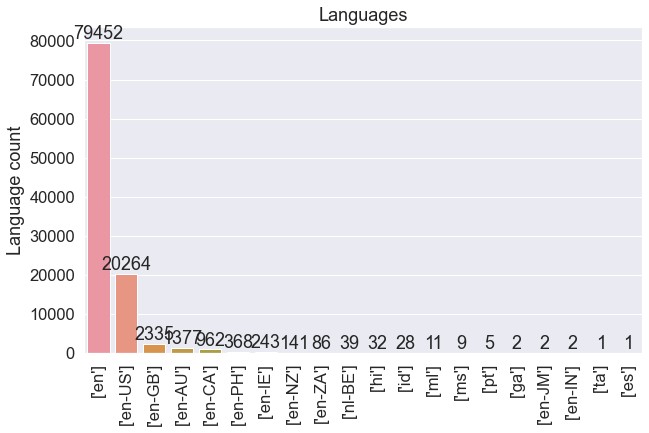

In [51]:

x = metadata.language.value_counts().index
y = metadata.language.value_counts()
ax = sns.barplot(x=x, y=y)
ax.bar_label(ax.containers[0])
plt.title("Languages")
plt.xticks(rotation=90)
plt.ylabel("Language count")
plt.show()


### Description length

In [52]:
metadata['show_descrlen']  = metadata['show_description'].str.len()
metadata['episode_descrlen']  = metadata['episode_description'].str.len()

metadata.head(2)

,show_uri,show_name,show_description,publisher,language,rss_link,episode_uri,episode_name,episode_description,duration,show_filename_prefix,episode_filename_prefix,show_uri_strp,category,show_descrlen,episode_descrlen
0,spotify:show:2NYtxEZyYelR6RMKmjfPLB,Kream in your Koffee,A 20-something blunt female takes on the world...,Katie Houle,['en'],https://anchor.fm/s/11b84b68/podcast/rss,spotify:episode:000A9sRBYdVh66csG2qEdj,1: It’s Christmas Time!,On the first ever episode of Kream in your Kof...,12.700133,show_2NYtxEZyYelR6RMKmjfPLB,000A9sRBYdVh66csG2qEdj,2NYtxEZyYelR6RMKmjfPLB,Leisure,176.0,191.0
1,spotify:show:15iWCbU7QoO23EndPEO6aN,Morning Cup Of Murder,Ever wonder what murder took place on today in...,Morning Cup Of Murder,['en'],https://anchor.fm/s/b07181c/podcast/rss,spotify:episode:000HP8n3hNIfglT2wSI2cA,The Goleta Postal Facility shootings- January ...,"See something, say something. It’s a mantra ma...",6.019383,show_15iWCbU7QoO23EndPEO6aN,000HP8n3hNIfglT2wSI2cA,15iWCbU7QoO23EndPEO6aN,True Crime,409.0,1056.0


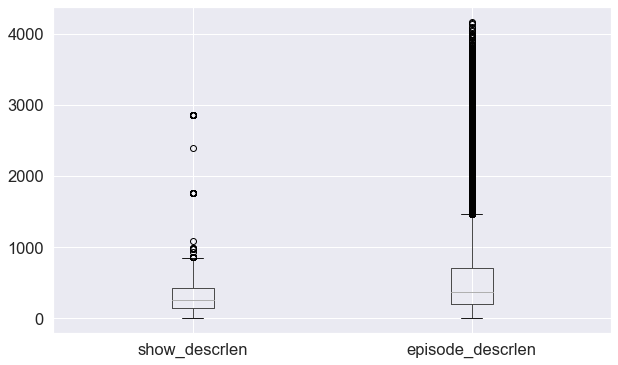

In [53]:
metadata.boxplot(column=['show_descrlen', 'episode_descrlen'], return_type='axes');

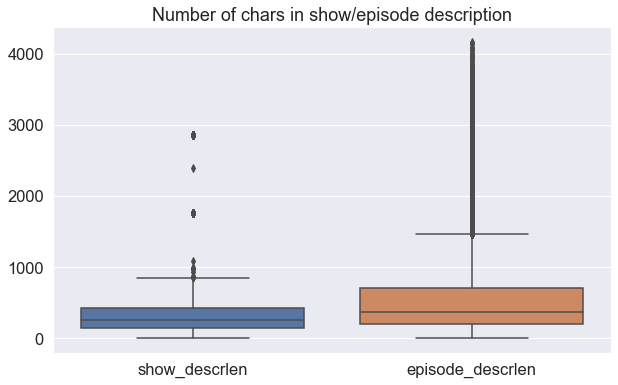

In [54]:
df = metadata[['show_descrlen', 'episode_descrlen']]

ax = sns.boxplot(data=df)
plt.title("Number of chars in show/episode description")
plt.show()


In [55]:

max_show_descrlen_idx = metadata['show_descrlen'].idxmax()
max_episode_descrlen_idx = metadata['episode_descrlen'].idxmax()
print("Longest show description at row ", max_show_descrlen_idx)
print("Longest episode description at row ", max_episode_descrlen_idx)



min_show_descrlen_idx = metadata['show_descrlen'].idxmin()
min_episode_descrlen_idx = metadata['episode_descrlen'].idxmin()
print("shortest show description at row ", min_show_descrlen_idx)
print("shortest episode description at row ", min_episode_descrlen_idx)




Longest show description at row  6132
Longest episode description at row  76222
shortest show description at row  3792
shortest episode description at row  14161


In [56]:
# Todo, die description fully krijgen
print(metadata.iloc[max_show_descrlen_idx]['episode_description'])

display((metadata['episode_description'][max_show_descrlen_idx]))

David does a quick recap of the highlights of his interview with credit repair specialist Chris LaHage from Speedycreditrepair.com. No matter where you are in the home buying process, your credit score is a major factor in helping you land that dream house. The difference of a few points could mean the difference of hundreds […]


'David does a quick recap of the highlights of his interview with credit repair specialist Chris LaHage from Speedycreditrepair.com. No matter where you are in the home buying process, your credit score is a major factor in helping you land that dream house. The difference of a few points could mean the difference of hundreds […]'

In [57]:
display(metadata.iloc[max_show_descrlen_idx])

show_uri                                 spotify:show:0vhUO6Sg4XSC1TAZC6Xy7k
show_name                                                  How to Buy a Home
show_description           Looking for answers – Can I buy a home? How do...
publisher                                                       David Sidoni
language                                                           ['en-US']
rss_link                             https://anchor.fm/s/961f9dc/podcast/rss
episode_uri                           spotify:episode:0RzNRrWjn3GhISLx2jnNJn
episode_name               Ep. 8 – Quick Credit Tips For First Time Home ...
episode_description        David does a quick recap of the highlights of ...
duration                                                             13.7674
show_filename_prefix                             show_0vhUO6Sg4XSC1TAZC6Xy7k
episode_filename_prefix                               0RzNRrWjn3GhISLx2jnNJn
show_uri_strp                                         0vhUO6Sg4XSC1TAZC6Xy7k

In [58]:
def display_text_max_col_width(df, width):
    with pd.option_context('display.max_colwidth', width):
        print(df)
print("\n------ shortest episode description has length ", len(metadata.iloc[min_episode_descrlen_idx]['episode_description']))
print(metadata.iloc[min_episode_descrlen_idx]['episode_description'])
print(repr(metadata.iloc[min_episode_descrlen_idx]['episode_description']))

print("\n------ Longest episode description has length ", len(metadata.iloc[max_episode_descrlen_idx]["episode_description"]))
display_text_max_col_width(metadata.iloc[max_episode_descrlen_idx]["episode_description"], 800)


------ shortest episode description has length  1
 
' '

------ Longest episode description has length  4174
Victoria (Alexandrina Victoria; 24 May 1819 – 22 January 1901) was Queen of the United Kingdom of Great Britain and Ireland from 20 June 1837 until her death. On 1 May 1876, she adopted the additional title of Empress of India. Known as the Victorian era, her reign of 63 years and seven months was longer than that of any of her predecessors. It was a period of industrial, cultural, political, scientific, and military change within the United Kingdom, and was marked by a great expansion of the British Empire.  Victoria was the daughter of Prince Edward, Duke of Kent and Strathearn (the fourth son of King George III), and Princess Victoria of Saxe-Coburg-Saalfeld. After both the Duke and his father died in 1820, she was raised under close supervision by her mother and her comptroller, John Conroy. She inherited the throne aged 18 after her father's three elder brothers died witho

In [59]:
print("\n------ shortest show description has length ", len(metadata.iloc[min_show_descrlen_idx]['show_description']))
print(metadata.iloc[min_show_descrlen_idx]['show_description'])
print(repr(metadata.iloc[min_show_descrlen_idx]['show_description']))

print("\n------ Longest show description has length ", len(metadata.iloc[max_show_descrlen_idx]["show_description"]))
display_text_max_col_width(metadata.iloc[max_show_descrlen_idx]["show_description"], 800)




------ shortest show description has length  1
.
'.'

------ Longest show description has length  2864
Looking for answers – Can I buy a home? How do I even do this? When do I start planning? Where should a first time home buyer start? Right here: real info from a real expert. This is free advice for anyone thinking they want to buy a house someday from an industry insider with years of hands-on experience. David Sidoni, the #HowtoBuyaHomeGuy, gives you the playbook on the dos and don’ts of buying your first house. From planning for the big step year ahead of time, right down to the nitty-gritty of the actual transaction, David explains how to plan, prepare for, and ultimately navigate the home buying process for those that don’t have a clue on how this all works. For far too long the real estate industry has either ignored first time home buyers or handed them off to novice agents with little training or expertise – and that sucks for you. So David decided to reach out directly to yo

In [60]:
metadata.head(4)

,show_uri,show_name,show_description,publisher,language,rss_link,episode_uri,episode_name,episode_description,duration,show_filename_prefix,episode_filename_prefix,show_uri_strp,category,show_descrlen,episode_descrlen
0,spotify:show:2NYtxEZyYelR6RMKmjfPLB,Kream in your Koffee,A 20-something blunt female takes on the world...,Katie Houle,['en'],https://anchor.fm/s/11b84b68/podcast/rss,spotify:episode:000A9sRBYdVh66csG2qEdj,1: It’s Christmas Time!,On the first ever episode of Kream in your Kof...,12.700133,show_2NYtxEZyYelR6RMKmjfPLB,000A9sRBYdVh66csG2qEdj,2NYtxEZyYelR6RMKmjfPLB,Leisure,176.0,191.0
1,spotify:show:15iWCbU7QoO23EndPEO6aN,Morning Cup Of Murder,Ever wonder what murder took place on today in...,Morning Cup Of Murder,['en'],https://anchor.fm/s/b07181c/podcast/rss,spotify:episode:000HP8n3hNIfglT2wSI2cA,The Goleta Postal Facility shootings- January ...,"See something, say something. It’s a mantra ma...",6.019383,show_15iWCbU7QoO23EndPEO6aN,000HP8n3hNIfglT2wSI2cA,15iWCbU7QoO23EndPEO6aN,True Crime,409.0,1056.0
2,spotify:show:6vZRgUFTYwbAA79UNCADr4,Inside The 18 : A Podcast for Goalkeepers by G...,Inside the 18 is your source for all things Go...,Inside the 18 GK Media,['en'],https://anchor.fm/s/81a072c/podcast/rss,spotify:episode:001UfOruzkA3Bn1SPjcdfa,Ep.36 - Incorporating a Singular Goalkeeping C...,Today’s episode is a sit down Michael and Omar...,43.616333,show_6vZRgUFTYwbAA79UNCADr4,001UfOruzkA3Bn1SPjcdfa,6vZRgUFTYwbAA79UNCADr4,Sports,597.0,638.0
3,spotify:show:5BvKEjaMSuvUsGROGi2S7s,Arrowhead Live!,Your favorite podcast for everything @Chiefs! ...,Arrowhead Live!,['en-US'],https://anchor.fm/s/917dba4/podcast/rss,spotify:episode:001i89SvIQgDuuyC53hfBm,Episode 1: Arrowhead Live! Debut,Join us as we take a look at all current Chief...,58.189200,show_5BvKEjaMSuvUsGROGi2S7s,001i89SvIQgDuuyC53hfBm,5BvKEjaMSuvUsGROGi2S7s,Sports,156.0,233.0


### Duration of each podcast

Total duration 3565985 minutes 
Mean duration 34 minutes


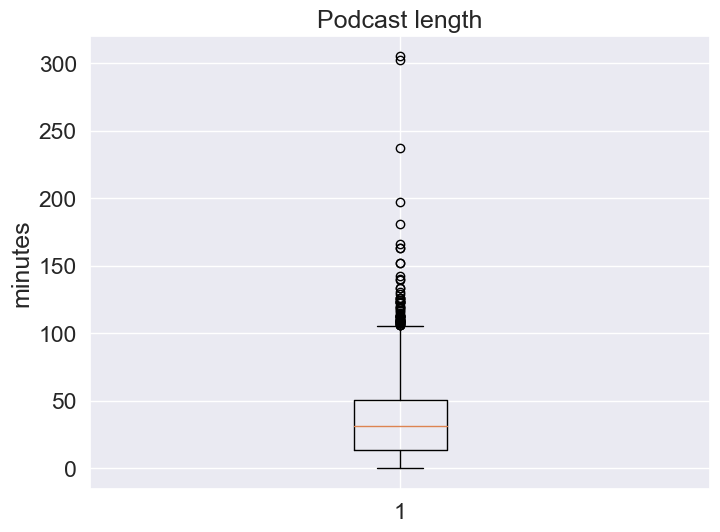

In [61]:
# df['duration'] = durations
print("Total duration {:0.0f} minutes ".format(metadata['duration'].sum()))
print("Mean duration {:0.0f} minutes".format(metadata['duration'].mean()))

fig1, ax1 = plt.subplots(figsize=(8, 6), dpi=100)
ax1.set_title('Podcast length')
ax1.boxplot(metadata['duration'])
plt.ylabel('minutes')
plt.show()

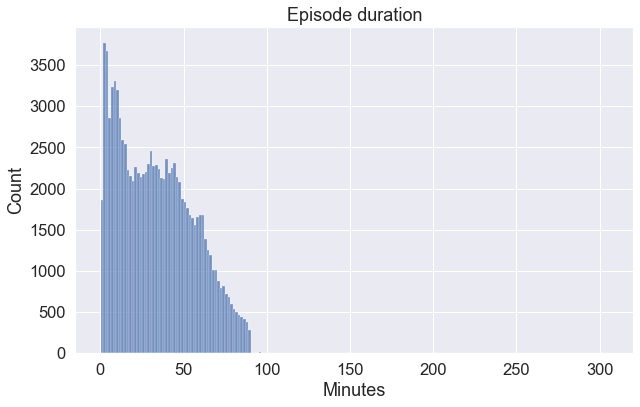

In [62]:
plt.title("Episode duration")
plt.xlabel("Minutes")
plt.ylabel("Count")
sns.histplot(data=metadata, x="duration")
plt.show()

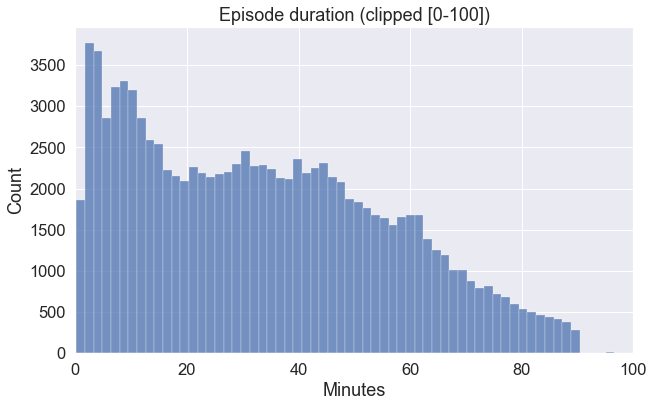

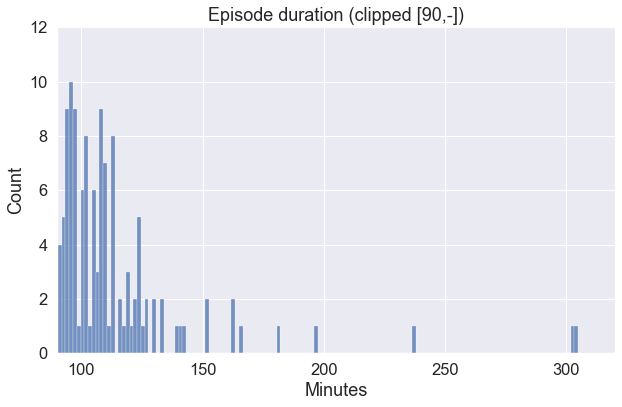

In [63]:
fig, ax = plt.subplots()
plt.title("Episode duration (clipped [0-100])")
plt.xlabel("Minutes")
plt.ylabel("Count")
sns.histplot(data=metadata, x="duration")
ax.set_xlim(0,100)
plt.show()

fig, ax = plt.subplots()
plt.title("Episode duration (clipped [90,-])")
plt.xlabel("Minutes")
plt.ylabel("Count")
sns.histplot(data=metadata, x="duration")
ax.set_xlim(90)
ax.set_ylim(0,12)
plt.show()




### Distributions of categories

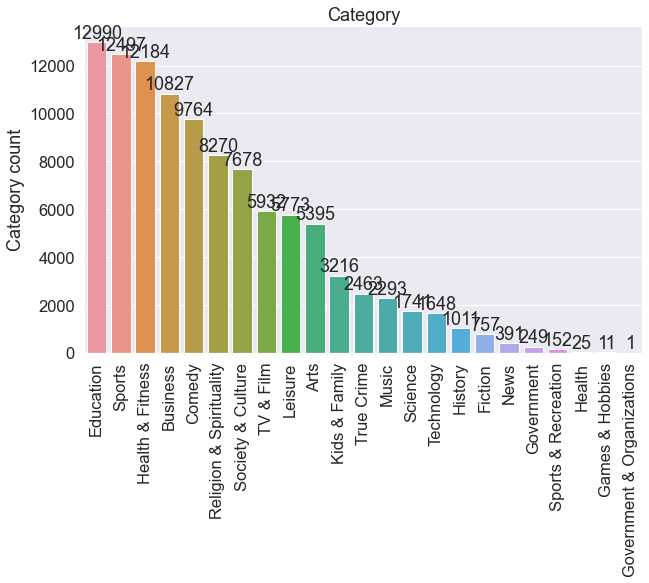

In [64]:

x = metadata.category.value_counts().index
y = metadata.category.value_counts()
ax = sns.barplot(x=x, y=y)
ax.bar_label(ax.containers[0])
plt.title("Category")
plt.xticks(rotation=90)
plt.ylabel("Category count")
plt.show()



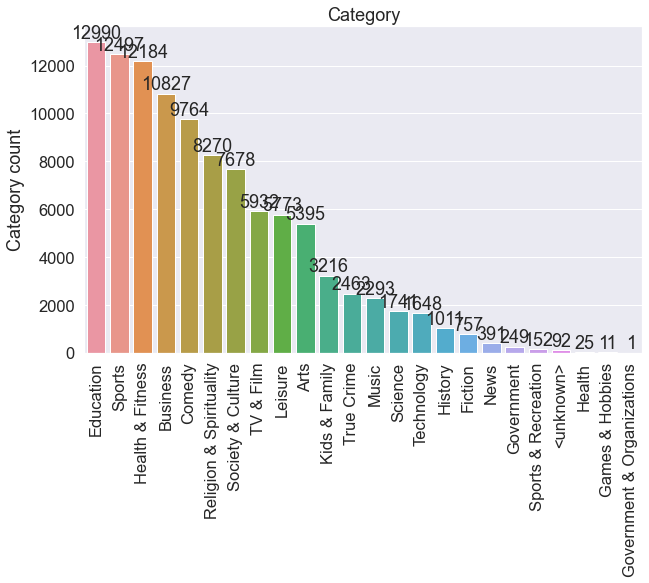

In [65]:

metadata["cat_unk"] = metadata.category.fillna('<unknown>')

x = metadata.cat_unk.value_counts().index
y = metadata.cat_unk.value_counts()
ax = sns.barplot(x=x, y=y)
ax.bar_label(ax.containers[0])
plt.title("Category")
plt.xticks(rotation=90)
plt.ylabel("Category count")
plt.show()
    

### Most popular shows

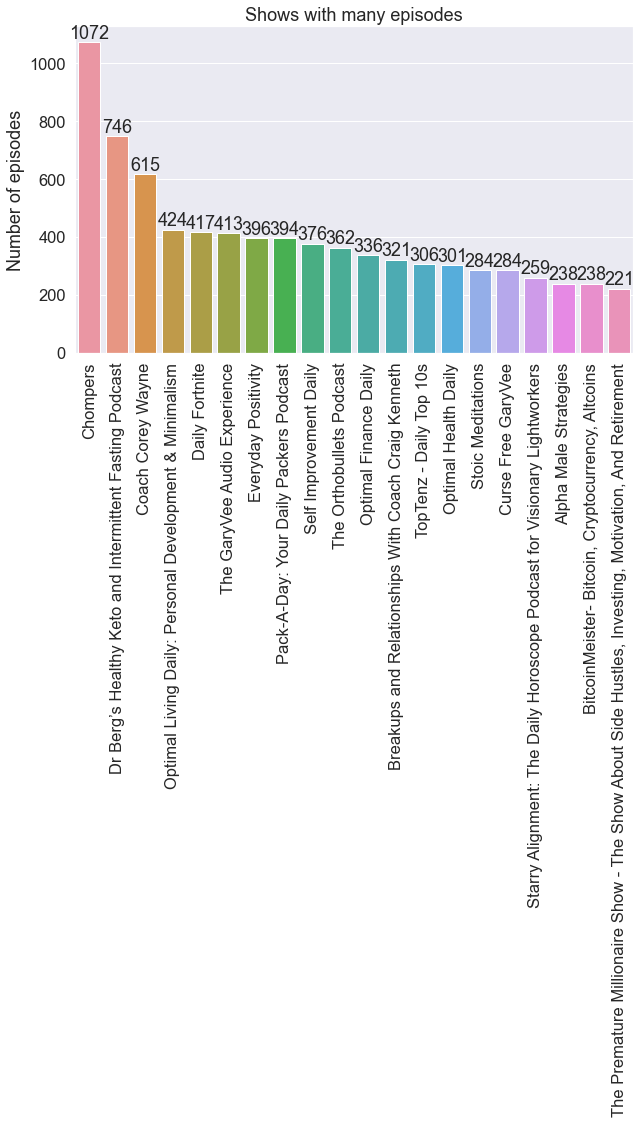

In [66]:

x = metadata.show_name.value_counts().index[:20]
y = metadata.show_name.value_counts()[:20]
ax = sns.barplot(x=x, y=y)
ax.bar_label(ax.containers[0])
plt.title("Shows with many episodes")
plt.xticks(rotation=90)
plt.ylabel("Number of episodes")
plt.show()

### Most popular publishers

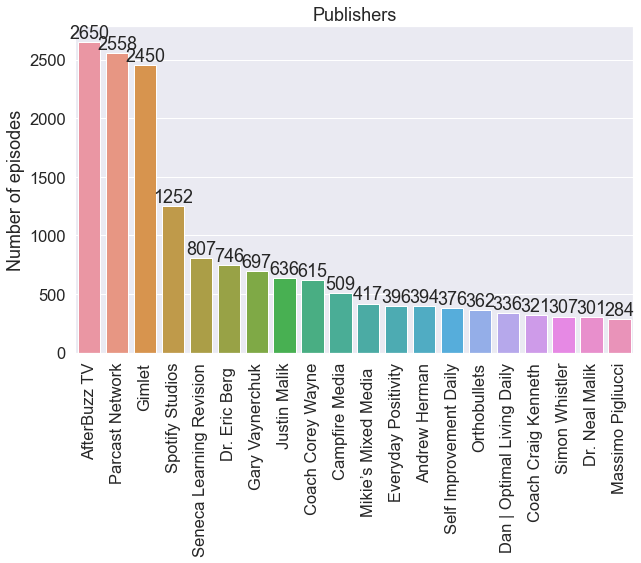

In [67]:
x = metadata.publisher.value_counts().index[:20]
y = metadata.publisher.value_counts()[:20]
ax = sns.barplot(x=x, y=y)
ax.bar_label(ax.containers[0])
plt.title("Publishers")
plt.xticks(rotation=90)
plt.ylabel("Number of episodes")
plt.show()

In [68]:
metadata.head()

,show_uri,show_name,show_description,publisher,language,rss_link,episode_uri,episode_name,episode_description,duration,show_filename_prefix,episode_filename_prefix,show_uri_strp,category,show_descrlen,episode_descrlen,cat_unk
0,spotify:show:2NYtxEZyYelR6RMKmjfPLB,Kream in your Koffee,A 20-something blunt female takes on the world...,Katie Houle,['en'],https://anchor.fm/s/11b84b68/podcast/rss,spotify:episode:000A9sRBYdVh66csG2qEdj,1: It’s Christmas Time!,On the first ever episode of Kream in your Kof...,12.700133,show_2NYtxEZyYelR6RMKmjfPLB,000A9sRBYdVh66csG2qEdj,2NYtxEZyYelR6RMKmjfPLB,Leisure,176.0,191.0,Leisure
1,spotify:show:15iWCbU7QoO23EndPEO6aN,Morning Cup Of Murder,Ever wonder what murder took place on today in...,Morning Cup Of Murder,['en'],https://anchor.fm/s/b07181c/podcast/rss,spotify:episode:000HP8n3hNIfglT2wSI2cA,The Goleta Postal Facility shootings- January ...,"See something, say something. It’s a mantra ma...",6.019383,show_15iWCbU7QoO23EndPEO6aN,000HP8n3hNIfglT2wSI2cA,15iWCbU7QoO23EndPEO6aN,True Crime,409.0,1056.0,True Crime
2,spotify:show:6vZRgUFTYwbAA79UNCADr4,Inside The 18 : A Podcast for Goalkeepers by G...,Inside the 18 is your source for all things Go...,Inside the 18 GK Media,['en'],https://anchor.fm/s/81a072c/podcast/rss,spotify:episode:001UfOruzkA3Bn1SPjcdfa,Ep.36 - Incorporating a Singular Goalkeeping C...,Today’s episode is a sit down Michael and Omar...,43.616333,show_6vZRgUFTYwbAA79UNCADr4,001UfOruzkA3Bn1SPjcdfa,6vZRgUFTYwbAA79UNCADr4,Sports,597.0,638.0,Sports
3,spotify:show:5BvKEjaMSuvUsGROGi2S7s,Arrowhead Live!,Your favorite podcast for everything @Chiefs! ...,Arrowhead Live!,['en-US'],https://anchor.fm/s/917dba4/podcast/rss,spotify:episode:001i89SvIQgDuuyC53hfBm,Episode 1: Arrowhead Live! Debut,Join us as we take a look at all current Chief...,58.189200,show_5BvKEjaMSuvUsGROGi2S7s,001i89SvIQgDuuyC53hfBm,5BvKEjaMSuvUsGROGi2S7s,Sports,156.0,233.0,Sports
4,spotify:show:7w3h3umpH74veEJcbE6xf4,FBoL,"The comedy podcast about toxic characters, wri...",Emily Edwards,['en'],https://www.fuckboisoflit.com/episodes?format=rss,spotify:episode:0025RWNwe2lnp6HcnfzwzG,"The Lion, The Witch, And The Wardrobe - Ashley...",The modern morality tail of how to stay good f...,51.782050,show_7w3h3umpH74veEJcbE6xf4,0025RWNwe2lnp6HcnfzwzG,7w3h3umpH74veEJcbE6xf4,Arts,341.0,472.0,Arts
